In [411]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn as sk
import scipy as sp
import os
from joblib import dump, load
from itertools import combinations, combinations_with_replacement
from functools import reduce
from time import time
from pprint import pprint
from IPython import display

from statsmodels.iolib.smpickle import load_pickle
from statsmodels.datasets import get_rdataset
from statsmodels.regression import linear_model as lm
from statsmodels.regression.linear_model import OLS
from statsmodels.discrete import discrete_model as dm
from statsmodels.tools import add_constant

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression

import seaborn as sns

## *Best Subset Selection*

In [102]:
df = get_rdataset('Credit', 'ISLR', True).data

In [103]:
df.head()

ID   Income  Limit  Rating  Cards  Age  Education  Gender Student Married  \
0   1   14.891   3606     283      2   34         11    Male      No     Yes   
1   2  106.025   6645     483      3   82         15  Female     Yes     Yes   
2   3  104.593   7075     514      4   71         11    Male      No      No   
3   4  148.924   9504     681      3   36         11  Female      No      No   
4   5   55.882   4897     357      2   68         16    Male      No     Yes   

   Ethnicity  Balance  
0  Caucasian      333  
1      Asian      903  
2      Asian      580  
3      Asian      964  
4  Caucasian      331

In [104]:
df.Ethnicity.unique()

array(['Caucasian', 'Asian', 'African American'], dtype=object)

In [105]:
df.Ethnicity = df.Ethnicity.apply(lambda et: 0 if et=="Caucasian" 
                                        else (1 if et=="Asian"
                                        else 0))

In [106]:
df.Gender.unique()

array([' Male', 'Female'], dtype=object)

In [107]:
df["Gender"] = df["Gender"].apply(lambda gender: 1 if gender==" Male" else 0)

In [108]:
df.head()

ID   Income  Limit  Rating  Cards  Age  Education  Gender Student Married  \
0   1   14.891   3606     283      2   34         11       1      No     Yes   
1   2  106.025   6645     483      3   82         15       0     Yes     Yes   
2   3  104.593   7075     514      4   71         11       1      No      No   
3   4  148.924   9504     681      3   36         11       0      No      No   
4   5   55.882   4897     357      2   68         16       1      No     Yes   

   Ethnicity  Balance  
0          0      333  
1          1      903  
2          1      580  
3          1      964  
4          0      331

In [109]:
df["Student"].unique()

array(['No', 'Yes'], dtype=object)

In [110]:
df["Married"].unique()

array(['Yes', 'No'], dtype=object)

In [111]:
df[["Student", "Married"]] = df[["Student", "Married"]].applymap(lambda ans: 1 if ans=="Yes" else 0)

In [112]:
df.columns

Index(['ID', 'Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education',
       'Gender', 'Student', 'Married', 'Ethnicity', 'Balance'],
      dtype='object')

In [113]:
df_predictors = df.drop(columns=["Ethnicity"])
df_predictors.head()

ID   Income  Limit  Rating  Cards  Age  Education  Gender  Student  \
0   1   14.891   3606     283      2   34         11       1        0   
1   2  106.025   6645     483      3   82         15       0        1   
2   3  104.593   7075     514      4   71         11       1        0   
3   4  148.924   9504     681      3   36         11       0        0   
4   5   55.882   4897     357      2   68         16       1        0   

   Married  Balance  
0        1      333  
1        1      903  
2        0      580  
3        0      964  
4        1      331

In [114]:
df_to_predict = df["Ethnicity"]

In [115]:
for i in combinations(df_predictors.columns, 1):
    print(i)

('ID',)
('Income',)
('Limit',)
('Rating',)
('Cards',)
('Age',)
('Education',)
('Gender',)
('Student',)
('Married',)
('Balance',)


In [116]:
def best_subset_selection(data, y):
    models = []
    rss = []
    p = len(data.columns)
    for k in range(1, p+1):
        temp_models = []
        rss.append([])
        for comb in combinations(data.columns, k):
            X = add_constant(data[list(comb)])
            temp_models.append( lm.OLS(y, X).fit() )
            #temp_models.append( dm.Logit(y, X).fit() )
            
            rss[-1].append(temp_models[-1].ssr)
        best_model = reduce(lambda m1,m2: m1 if m1.ssr<=m2.ssr else m2, temp_models)
        models.append(best_model)
        
        
    best_rss = list(map(lambda m: m.ssr, models))
    return rss, best_rss        

In [117]:
all_rss, best_rss = best_subset_selection(df_predictors, df_to_predict)

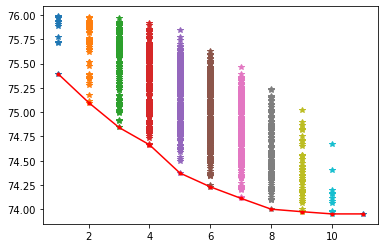

In [118]:
n = len(df_predictors.columns)
for p, results in enumerate(all_rss):
    plt.plot([p+1]*len(results), results, "*")
plt.plot(range(1, len(best_rss)+1), best_rss, "r.-")
plt.show()

## *Stepwise Selection*

### > Forward Stepwise Selection

- Similar to SBS, except that, to reduce the number of iterations, the descriptors selected in (k-1) are assumed in the model of k variables.

### > Backward Stepwise Selection

- Same idea, but backwards. Starts with all descriptors, and removes variables to find the best model. The (k)th iteration assumes that the previously removed variables are not part of the solution.

## Choosing Optimal Model

In [119]:
def sbs(data, y):
    models = []
    p = len(data.columns)

    for k in range(1, p+1):
        temp_models = []
        for comb in combinations(data.columns, k):
            X = add_constant(data[list(comb)])
            temp_models.append( lm.OLS(y, X).fit() )
                    
        best_model = reduce(lambda m1,m2: m1 if m1.ssr<=m2.ssr else m2, temp_models)
        models.append(best_model)
        
    return models      

In [120]:
models = sbs(df_predictors, df_to_predict)

In [121]:
X = add_constant(df_predictors)
temp_model = lm.OLS(df_to_predict, X).fit()
pred = temp_model.predict(X)
var = np.mean( (pred - df_to_predict)**2 )**0.5
del temp_model

In [122]:
cps = []
for i in range(1, len(models)+1):
    model = models[i-1]
    cp = model.ssr + 2*i*var**2
    cps.append(cp)

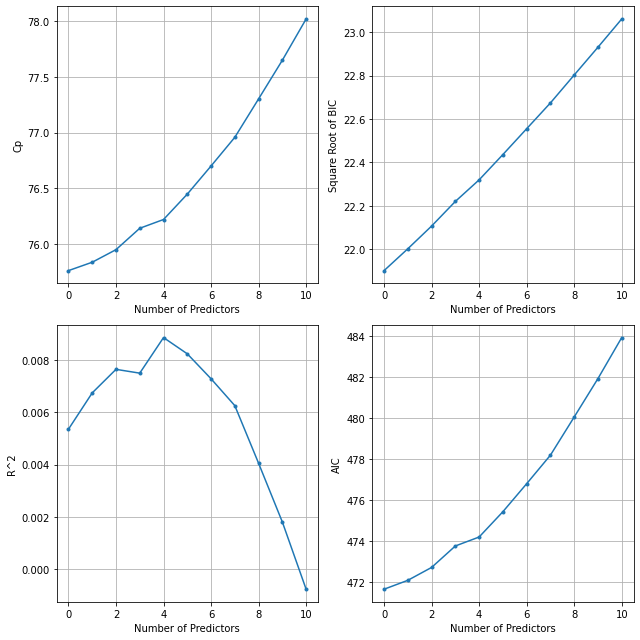

In [124]:
f, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(9,9))

axes[0][0].plot(cps, ".-")
axes[0][0].set_xlabel("Number of Predictors")
axes[0][0].set_ylabel("Cp")
axes[0][0].grid()

axes[0][1].plot(list(map(lambda model: np.sqrt(model.bic), models)), ".-")
axes[0][1].set_xlabel("Number of Predictors")
axes[0][1].set_ylabel("Square Root of BIC")
axes[0][1].grid()

axes[1][0].plot(list(map(lambda model: model.rsquared_adj, models)), ".-")
axes[1][0].set_xlabel("Number of Predictors")
axes[1][0].set_ylabel("R^2")
axes[1][0].grid()

axes[1][1].plot(list(map(lambda model: model.aic, models)), ".-")
axes[1][1].set_xlabel("Number of Predictors")
axes[1][1].set_ylabel("AIC")
axes[1][1].grid()

f.tight_layout()

In [152]:
def split_cv_data(cycle_n, X, y, cv_size):
    test_start = cycle_n * cv_size
    test_end = test_start + cv_size
    
    test_range = range(test_start, test_end)
    train_index = X.index.difference(test_range)
    
    X_train, y_train =  X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_range], y.iloc[test_range]
    
    return X_train, X_test, y_train, y_test

In [160]:
def mean_sqr_error(model, X, y):
    #ols = model.fit(X, y)
    pred = model.predict(X)
    err = ((pred-y)**2).mean()
    return err

In [173]:
def cross_validate(model, X, y, cv):
    n = int(len(X)//cv)
    error = []
    for i in range(n):
        X_train, X_test, y_train, y_test = split_cv_data(i, X, y, cv)
        m = model(y_train, X_train).fit()
        error.append( mean_sqr_error(m, X_test, y_test) )
    return np.mean(error)

In [175]:
cross_validate(lm.OLS, df_predictors, df_to_predict, 10)

0.19791900943192134

In [172]:
def sbs_columns(data, y):
    model_parameters = []
    p = len(data.columns)

    for k in range(1, p+1):
        best_parameters = None
        ssr = None
        for comb in combinations(data.columns, k):
            X = add_constant(data[list(comb)])
            model = lm.OLS(y, X).fit()
            
            if (best_parameters == None):
                ssr = model.ssr
                best_parameters = list(comb)
            else:
                if (model.ssr < ssr):
                    ssr = model.ssr
                    best_parameters = list(comb)
            
        model_parameters.append(best_parameters)
    return model_parameters  

In [182]:
def cv_sbs_results(X, y, winners, cv):
    model = lm.OLS
    errors = []
    
    for cols in winners:
        temp_X = X[cols]
        errors.append(cross_validate(model, temp_X, y, cv))
    return errors

In [183]:
columns = sbs_columns(df_predictors, df_to_predict)

In [184]:
cv_scores = cv_sbs_results(df_predictors, df_to_predict, columns, 10)

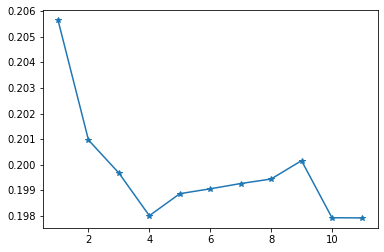

In [187]:
plt.plot(range(1,len(cv_scores)+1), cv_scores, "*-")

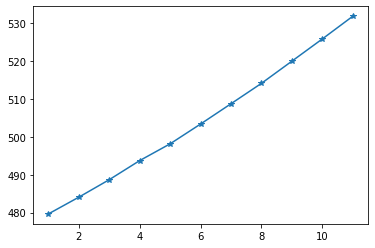

In [188]:
plt.plot(range(1,len(cv_scores)+1), list(map(lambda model: model.bic, models)), "*-")

In [197]:
pred = models[-1].predict(add_constant(df_predictors))
np.sqrt( ( (pred-df_to_predict)**2).mean() )

0.4299759449906938

## Principal Components

In [148]:
df = get_rdataset('Credit', "ISLR", True).data

In [149]:
df.head()

ID   Income  Limit  Rating  Cards  Age  Education  Gender Student Married  \
0   1   14.891   3606     283      2   34         11    Male      No     Yes   
1   2  106.025   6645     483      3   82         15  Female     Yes     Yes   
2   3  104.593   7075     514      4   71         11    Male      No      No   
3   4  148.924   9504     681      3   36         11  Female      No      No   
4   5   55.882   4897     357      2   68         16    Male      No     Yes   

   Ethnicity  Balance  
0  Caucasian      333  
1      Asian      903  
2      Asian      580  
3      Asian      964  
4  Caucasian      331

In [150]:
df.Gender = df.Gender.apply(lambda gen: 1 if gen == "Male" else 0)
df.Married = df.Married.apply(lambda ans: 1 if ans == "Yes" else 0)

In [151]:
df.head()

ID   Income  Limit  Rating  Cards  Age  Education  Gender Student  Married  \
0   1   14.891   3606     283      2   34         11       0      No        1   
1   2  106.025   6645     483      3   82         15       0     Yes        1   
2   3  104.593   7075     514      4   71         11       0      No        0   
3   4  148.924   9504     681      3   36         11       0      No        0   
4   5   55.882   4897     357      2   68         16       0      No        1   

   Ethnicity  Balance  
0  Caucasian      333  
1      Asian      903  
2      Asian      580  
3      Asian      964  
4  Caucasian      331

In [152]:
df.Student = df.Student.apply(lambda ans: 1 if ans == "Yes" else 0)
df.Ethnicity = df.Ethnicity.apply(lambda et: 0 if et == "Caucasian" 
                                                else (1 if et=="Asian"
                                                    else 2
                                                )
                                     )

In [153]:
df.head()

ID   Income  Limit  Rating  Cards  Age  Education  Gender  Student  \
0   1   14.891   3606     283      2   34         11       0        0   
1   2  106.025   6645     483      3   82         15       0        1   
2   3  104.593   7075     514      4   71         11       0        0   
3   4  148.924   9504     681      3   36         11       0        0   
4   5   55.882   4897     357      2   68         16       0        0   

   Married  Ethnicity  Balance  
0        1          0      333  
1        1          1      903  
2        0          1      580  
3        0          1      964  
4        1          0      331

In [154]:
df.drop(columns=["ID"], inplace=True)

In [155]:
df.head()

Income  Limit  Rating  Cards  Age  Education  Gender  Student  Married  \
0   14.891   3606     283      2   34         11       0        0        1   
1  106.025   6645     483      3   82         15       0        1        1   
2  104.593   7075     514      4   71         11       0        0        0   
3  148.924   9504     681      3   36         11       0        0        0   
4   55.882   4897     357      2   68         16       0        0        1   

   Ethnicity  Balance  
0          0      333  
1          1      903  
2          1      580  
3          1      964  
4          0      331

In [156]:
def standardization(x):
    return (x-x.mean())/x.std()

In [157]:
y = df.Ethnicity

In [158]:
df.apply(lambda col: standardization(col), axis = 1)

Income     Limit    Rating     Cards       Age  Education    Gender  \
0   -0.348954  2.995906 -0.099230 -0.360962 -0.331156  -0.352579 -0.362824   
1   -0.325420  2.983582 -0.134655 -0.377555 -0.337578  -0.371483 -0.379073   
2   -0.311356  2.999718 -0.116880 -0.359140 -0.327313  -0.355815 -0.361040   
3   -0.312050  2.994771 -0.123972 -0.363631 -0.351966  -0.360803 -0.364691   
4   -0.318926  3.002599 -0.112327 -0.355895 -0.310612  -0.346290 -0.357267   
..        ...       ...       ...       ...       ...        ...       ...   
395 -0.364306  2.982294 -0.122880 -0.371753 -0.348012  -0.363566 -0.374209   
396 -0.363896  2.986566 -0.116301 -0.371223 -0.318662  -0.360711 -0.375603   
397 -0.302457  3.005944 -0.090809 -0.344984 -0.295115  -0.339354 -0.349006   
398 -0.288929  3.006617 -0.084524 -0.337592 -0.280619  -0.321693 -0.338917   
399 -0.374765  2.965214 -0.134337 -0.383077 -0.347283  -0.381864 -0.386111   

      Student   Married  Ethnicity   Balance  
0   -0.362824 -0.361893  -0.362824 -0.052659  
1   -0.378567 -0.378567  -0.378567  0.077883  
2   -0.361040 -0.361040  -0.360565 -0.085529  
3   -0.364691 -0.364691  -0.364338 -0.023938  
4   -0.357267 -0.356581  -0.357267 -0.130166  
..        ...       ...        ...       ...  
395 -0.374209 -0.373390  -0.374209  0.084240  
396 -0.375603 -0.375603  -0.373851  0.044887  
397 -0.349006 -0.348202  -0.349006 -0.238006  
398 -0.338917 -0.337592  -0.338917 -0.338917  
399 -0.386111 -0.386111  -0.385504  0.199947  

[400 rows x 11 columns]

In [159]:
pca = PCA()
X_reduced = pca.fit_transform(df.apply(lambda col: standardization(col), axis = 1))

In [160]:
X_reduced

array([[ 1.45063701e-02, -7.73264221e-03,  1.39006739e-02, ...,
         3.25193088e-05,  1.77314168e-05,  6.40069955e-16],
       [ 1.50218104e-01, -6.75591767e-03, -7.63277277e-03, ...,
         1.00916426e-04,  1.31777598e-04,  1.24682849e-16],
       [-1.93983696e-02, -2.90249520e-02, -1.22363287e-03, ...,
        -1.83677197e-04, -3.11744066e-06, -2.16446319e-16],
       ...,
       [-1.80682022e-01, -2.30483279e-02, -1.23921367e-03, ...,
         2.10651100e-04,  1.37330531e-04, -3.54494685e-16],
       [-2.86314202e-01, -3.21816854e-02, -5.13672386e-03, ...,
         4.30786088e-04, -4.71664557e-05, -1.96093643e-16],
       [ 2.77556165e-01,  2.07780107e-02, -2.09024619e-03, ...,
        -1.39293616e-04, -5.36182114e-06, -2.29282347e-16]])

In [161]:
pca.components_.T[:4,:5]

array([[-0.10799779, -0.24386209,  0.02836501,  0.91277763,  0.01456448],
       [-0.07077289, -0.1863828 , -0.05721094, -0.1530841 , -0.90161417],
       [-0.14391235,  0.52727874,  0.77013776,  0.0084721 , -0.06688837],
       [-0.07402479, -0.13872698,  0.00588586, -0.13982444,  0.12806266]])

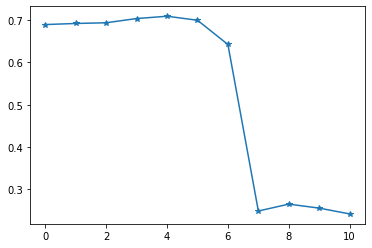

In [174]:
lm = LinearRegression()
cv = KFold(n_splits=10, shuffle=True)

mse = []

for i in np.arange(1, len(df.columns)+1):
    score = -cross_val_score(lm, X_reduced[:,:i], y=y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(mse, '-*')


 # *Labs* <br> 
 
 

> ## Model Selection Through Statistics

### Best Subset Selection

In [5]:
df = get_rdataset("Hitters", "ISLR", cache=True).data

In [6]:
df.head()

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
-Andy Allanson       293    66      1    30   29     14      1     293     66   
-Alan Ashby          315    81      7    24   38     39     14    3449    835   
-Alvin Davis         479   130     18    66   72     76      3    1624    457   
-Andre Dawson        496   141     20    65   78     37     11    5628   1575   
-Andres Galarraga    321    87     10    39   42     30      2     396    101   

                   CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  \
-Andy Allanson          1     30    29      14      A        E      446   
-Alan Ashby            69    321   414     375      N        W      632   
-Alvin Davis           63    224   266     263      A        W      880   
-Andre Dawson         225    828   838     354      N        E      200   
-Andres Galarraga      12     48    46      33      N        E      805   

                   Assists  Errors  Salary NewLeague  
-Andy Allanson          33      20     NaN         A  
-Alan Ashby             43      10   475.0         N  
-Alvin Davis            82      14   480.0         A  
-Andre Dawson           11       3   500.0         N  
-Andres Galarraga       40       4    91.5         N

In [8]:
df.isna().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [9]:
df = df.dropna()

In [16]:
#change categorical data into numerical data
X = df.drop(columns="Salary")
X = pd.get_dummies(X, columns=["League", "Division", "NewLeague"])
#X = X.drop(columns=["League", "Division", "NewLeague"])
y = df.Salary

In [17]:
X.head()

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
-Alan Ashby          315    81      7    24   38     39     14    3449    835   
-Alvin Davis         479   130     18    66   72     76      3    1624    457   
-Andre Dawson        496   141     20    65   78     37     11    5628   1575   
-Andres Galarraga    321    87     10    39   42     30      2     396    101   
-Alfredo Griffin     594   169      4    74   51     35     11    4408   1133   

                   CHmRun  ...  CWalks  PutOuts  Assists  Errors  League_A  \
-Alan Ashby            69  ...     375      632       43      10         0   
-Alvin Davis           63  ...     263      880       82      14         1   
-Andre Dawson         225  ...     354      200       11       3         0   
-Andres Galarraga      12  ...      33      805       40       4         0   
-Alfredo Griffin       19  ...     194      282      421      25         1   

                   League_N  Division_E  Division_W  NewLeague_A  NewLeague_N  
-Alan Ashby               1           0           1            0            1  
-Alvin Davis              0           0           1            1            0  
-Andre Dawson             1           1           0            0            1  
-Andres Galarraga         1           1           0            0            1  
-Alfredo Griffin          0           0           1            1            0  

[5 rows x 22 columns]

In [2]:
def train_best(data, y, k):
    best = None
    
    for comb in combinations(data.columns, k):
        X = add_constant(data[list(comb)])
        model = lm.OLS(y, X).fit()
        
        if best == None:
            best = model
        elif model.ssr < best.ssr:
            best = model
        
    best = {
            "model" : best,
            "rss" : best.ssr
            }
    return best

In [3]:
def bss(data, y, p=None):
    models = pd.DataFrame(columns=["model", "rss"])
    
    if p == None or p > len(data.columns):
        p = len(data.columns)
        
    for k in range(1, p+1):
        tic = time()
        best_in_train = train_best(data, y, k)
        models.loc[k] = best_in_train
        toc = time()
        
        print(toc-tic)
    return models

In [ ]:
best_models = bss(X,y, 5)

In [92]:
best_models

model              rss
1  <statsmodels.regression.linear_model.Regressio...  36179679.255042
2  <statsmodels.regression.linear_model.Regressio...  30646559.890373
3  <statsmodels.regression.linear_model.Regressio...  29249296.855867
4  <statsmodels.regression.linear_model.Regressio...  27970851.815816
5  <statsmodels.regression.linear_model.Regressio...  27149899.432012

In [102]:
for model in best_models.model:
    print(model.params)
    print("-----------")

const    274.580386
CRBI       0.790954
dtype: float64
-----------
const   -47.955902
Hits      3.300845
CRBI      0.689899
dtype: float64
-----------
const     -71.459220
Hits        2.803816
CRBI        0.682528
PutOuts     0.273581
dtype: float64
-----------
const          13.923104
Hits            2.675798
CRBI            0.681779
PutOuts         0.273500
Division_W   -139.953885
dtype: float64
-----------
const         -31.963527
AtBat          -1.440143
Hits            7.175320
CRBI            0.688208
PutOuts         0.290516
Division_E    129.731939
dtype: float64
-----------


In [155]:
best_models = bss(X,y)

0.06722903251647949
0.5795223712921143
4.270648241043091
29.592155933380127
98.70300126075745
297.2619376182556
680.6139514446259
1353.6417326927185
2241.44500041008
3107.0743477344513
3511.4790692329407
3316.7986686229706
2892.7050218582153
3421.2942295074463
1480.5387241840363
516.2851896286011
167.70003747940063
49.50396537780762
10.50029969215393
1.6719465255737305
0.18211770057678223
0.015972375869750977


In [163]:
m = best_models.loc[1,"model"]

In [190]:
os.makedirs("cap5/bss", exist_ok=True)
for i, m in enumerate(best_models.model):
    m.save(f"cap5/bss/model_{i}.P")

In [162]:
best_models.model.apply(lambda m: m.rsquared)

1     0.321450
2     0.425224
3     0.451429
4     0.475407
5     0.490804
6     0.508715
7     0.514123
8     0.528557
9     0.534612
10    0.540495
11    0.542615
12    0.543630
13    0.544457
14    0.545216
15    0.545469
16    0.545766
17    0.545952
18    0.546095
19    0.546116
20    0.546116
21    0.546116
22    0.546116
Name: model, dtype: float64

Text(0.5, 0.98, 'Statistics for Best Subset Selection')

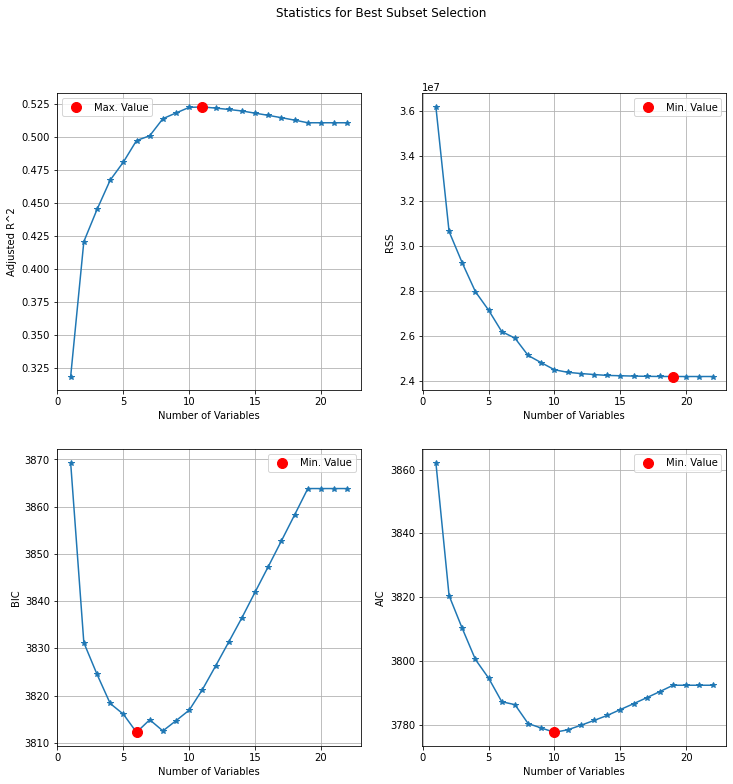

In [189]:
f, ax = plt.subplots(2,2, figsize=(12,12))

rsq_adj=best_models.model.apply(lambda m: m.rsquared_adj)
ax[0,0].plot(rsq_adj, "-*")
ax[0,0].plot(rsq_adj.argmax()+1,rsq_adj.max(), "ro", ms=10, label="Max. Value")
ax[0,0].set_xlabel("Number of Variables")
ax[0,0].set_ylabel("Adjusted R^2")
ax[0,0].grid()
ax[0,0].legend()
del rsq_adj

ssr = best_models.model.apply(lambda m: m.ssr)
ax[0,1].plot(ssr, "-*")
ax[0,1].plot(ssr.argmin()+1, ssr.min(), "ro", ms=10, label="Min. Value")
ax[0,1].set_xlabel("Number of Variables")
ax[0,1].set_ylabel("RSS")
ax[0,1].legend()
ax[0,1].grid()
del ssr

bic = best_models.model.apply(lambda m: m.bic)
ax[1,0].plot(bic, "-*")
ax[1,0].plot(bic.argmin()+1, bic.min(), "ro", ms= 10, label="Min. Value")
ax[1,0].set_xlabel("Number of Variables")
ax[1,0].set_ylabel("BIC")
ax[1,0].legend()
ax[1,0].grid()
del bic

aic = best_models.model.apply(lambda m: m.aic)
ax[1,1].plot(aic, "-*")
ax[1,1].plot(aic.argmin()+1, aic.min(), "ro", ms=10, label="Min. Value")
ax[1,1].set_xlabel("Number of Variables")
ax[1,1].set_ylabel("AIC")
ax[1,1].legend()
ax[1,1].grid()
del aic

f.suptitle("Statistics for Best Subset Selection")

The statistics give different values, that range from 6 to 19 variables. AIC and R^2 Adjusted 10 variables is ideal. In the case of RSS, that gives the more complex model, there is not much evolution after the 7 variables mark. In BIC, the 6 or 8 variables are basicly equal in result value. <br>

So something between 7 and 12 variables should suffice and give good results.

### Forward/Backward Stepwise Selection

In [242]:
def forward_train_best(data, y, predictor):
    best = None

    for p in data.columns.difference(predictor):
        cols = predictor + [p]
        X = add_constant(data[cols])
        
        model = lm.OLS(y, X).fit()       
        if best == None:
            best = model
        elif model.ssr < best.ssr:
            best = model
        
    best = {
            "model" : best,
            "rss" : best.ssr
            }
    
    return best, list(best["model"].params.index.difference(["const"]))

In [243]:
def forward_bss(data, y, p=None):
    models = pd.DataFrame(columns=["model", "rss"])
    
    if p == None or p > len(data.columns):
        p = len(data.columns)
    
    predictors = []
    for k in range(1, p+1):
        tic = time()
        (best_in_train, 
         predictors) = forward_train_best(data, y, predictors)
        models.loc[k] = best_in_train
        toc = time()
        
        print(toc-tic)
    return models

In [244]:
forward_best_models=forward_bss(X,y)

0.06553983688354492
0.05316281318664551
0.05497097969055176
0.055043935775756836
0.05803322792053223
0.06600046157836914
0.05909299850463867
0.06005716323852539
0.07204461097717285
0.062029361724853516
0.056005001068115234
0.05399918556213379
0.053468942642211914
0.05516648292541504
0.04608798027038574
0.0410456657409668
0.037999868392944336
0.03303194046020508
0.03297066688537598
0.02204418182373047
0.015032291412353516
0.009964942932128906


In [245]:
forward_best_models.model.apply(lambda m: m.rsquared)

1     0.321450
2     0.425224
3     0.451429
4     0.475407
5     0.490804
6     0.508715
7     0.513229
8     0.528139
9     0.534612
10    0.540495
11    0.542615
12    0.543630
13    0.544457
14    0.545216
15    0.545469
16    0.545766
17    0.545952
18    0.546095
19    0.546116
20    0.546116
21    0.546116
22    0.546116
Name: model, dtype: float64

In [246]:
for model in forward_best_models.model:
    print(model.params)
    print("-----------")

const    274.580386
CRBI       0.790954
dtype: float64
-----------
const   -47.955902
CRBI      0.689899
Hits      3.300845
dtype: float64
-----------
const     -71.459220
CRBI        0.682528
Hits        2.803816
PutOuts     0.273581
dtype: float64
-----------
const          13.923104
CRBI            0.681779
Hits            2.675798
PutOuts         0.273500
Division_W   -139.953885
dtype: float64
-----------
const          97.768412
CRBI            0.688208
Division_W   -129.731939
Hits            7.175320
PutOuts         0.290516
AtBat          -1.440143
dtype: float64
-----------
const          91.511798
AtBat          -1.868589
CRBI            0.643017
Division_W   -122.951534
Hits            7.604398
PutOuts         0.264308
Walks           3.697647
dtype: float64
-----------
const         109.787306
AtBat          -1.958885
CRBI            0.853762
Division_W   -127.122393
Hits            7.449877
PutOuts         0.253340
Walks           4.913140
CWalks         -0.305307
dtype: 

In [252]:
print(forward_best_models.loc[6,"model"].params,
      "-------------",
      best_models.loc[6, "model"].params,
      sep="\n")

const          91.511798
AtBat          -1.868589
CRBI            0.643017
Division_W   -122.951534
Hits            7.604398
PutOuts         0.264308
Walks           3.697647
dtype: float64
-------------
const          91.511798
AtBat          -1.868589
Hits            7.604398
Walks           3.697647
CRBI            0.643017
PutOuts         0.264308
Division_W   -122.951534
dtype: float64


Diferent Results, but not very distant to each other. 

### Backward Stepwise Selection

In [270]:
def backward_train_best(data, y, predictors):
    best = None

    for p in predictors:
        cols = predictors.difference([p])
        X = add_constant(data[cols])
        
        model = lm.OLS(y, X).fit()       
        if best == None:
            best = model
        elif model.ssr < best.ssr:
            best = model
        
    best = {
            "model" : best,
            "rss" : best.ssr
            }
    
    return best, best["model"].params.index.difference(["const"])

In [271]:
def backward_bss(data, y, p=None):
    models = pd.DataFrame(columns=["model", "rss"])
    
    if p == None or p > len(data.columns):
        p = len(data.columns)
    
    predictors = data.columns
    for k in range(p, 0, -1):
        tic = time()
        (best_in_train, 
         predictors) = backward_train_best(data, y, predictors)
        models.loc[k] = best_in_train
        toc = time()
        
        print(toc-tic)
    return models

In [301]:
backward_best_models=backward_bss(X,y).sort_index()

0.170029878616333
0.14001202583312988
0.13901185989379883
0.1169884204864502
0.13604521751403809
0.11102795600891113
0.09400534629821777
0.09099411964416504
0.0720055103302002
0.06796669960021973
0.08303332328796387
0.09105229377746582
0.05600404739379883
0.0359652042388916
0.03602480888366699
0.03100895881652832
0.020999670028686523
0.01604628562927246
0.012000083923339844
0.008999347686767578
0.006000518798828125
0.003000497817993164


In [302]:
backward_best_models.model.apply(lambda m: m.rsquared)

1     1.110223e-16
2     3.166062e-01
3     4.147791e-01
4     4.484661e-01
5     4.664051e-01
6     4.840589e-01
7     4.997274e-01
8     5.136174e-01
9     5.281386e-01
10    5.346124e-01
11    5.404950e-01
12    5.426153e-01
13    5.436302e-01
14    5.444570e-01
15    5.452164e-01
16    5.454692e-01
17    5.457656e-01
18    5.459518e-01
19    5.460945e-01
20    5.461159e-01
21    5.461159e-01
22    5.461159e-01
Name: model, dtype: float64

In [303]:
print("======= 7 VARIABLES SELECTION COMPARISON =======")
print("----Best Subsect Selection----")
print(best_models.loc[7, "model"].params)
print()
print("----Forward Stepwise Subsect Selection----")
print(forward_best_models.loc[7, "model"].params)
print()
print("----Backward Stepwise Subsect Selection----")
print(backward_best_models.loc[7, "model"].params)

======= 7 VARIABLES SELECTION COMPARISON =======
----Best Subsect Selection----
const          79.450947
Hits            1.283351
Walks           3.227426
CAtBat         -0.375235
CHits           1.495707
CHmRun          1.442054
PutOuts         0.236681
Division_W   -129.986643
dtype: float64

----Forward Stepwise Subsect Selection----
const         109.787306
AtBat          -1.958885
CRBI            0.853762
Division_W   -127.122393
Hits            7.449877
PutOuts         0.253340
Walks           4.913140
CWalks         -0.305307
dtype: float64

----Backward Stepwise Subsect Selection----
const         -35.529453
AtBat          -1.815893
CRuns           0.618788
Division_E    113.795860
Hits            7.359764
PutOuts         0.299579
Walks           3.512325
dtype: float64


In [304]:
def plot_model_test_statistcs(models, title):
    f, ax = plt.subplots(2,2, figsize=(12,12))

    rsq_adj=models.model.apply(lambda m: m.rsquared_adj)
    
    ax[0,0].plot(rsq_adj, "-*")
    ax[0,0].plot(rsq_adj.argmax()+1,rsq_adj.max(), "ro", ms=10, label="Max. Value")
    
    ax[0,0].set_xlabel("Number of Variables")
    ax[0,0].set_ylabel("Adjusted R^2")
    ax[0,0].grid()
    ax[0,0].legend()
    del rsq_adj

    ssr = models.model.apply(lambda m: m.ssr)
    
    ax[0,1].plot(ssr, "-*")
    ax[0,1].plot(ssr.argmin()+1, ssr.min(), "ro", ms=10, label="Min. Value")
    
    ax[0,1].set_xlabel("Number of Variables")
    ax[0,1].set_ylabel("RSS")
    ax[0,1].legend()
    ax[0,1].grid()
    del ssr

    bic = models.model.apply(lambda m: m.bic)
    
    ax[1,0].plot(bic, "-*")
    ax[1,0].plot(bic.argmin()+1, bic.min(), "ro", ms= 10, label="Min. Value")
    
    ax[1,0].set_xlabel("Number of Variables")
    ax[1,0].set_ylabel("BIC")
    ax[1,0].legend()
    ax[1,0].grid()
    del bic

    aic = models.model.apply(lambda m: m.aic)
    
    ax[1,1].plot(aic, "-*")
    ax[1,1].plot(aic.argmin()+1, aic.min(), "ro", ms=10, label="Min. Value")
    
    ax[1,1].set_xlabel("Number of Variables")
    ax[1,1].set_ylabel("AIC")
    ax[1,1].legend()
    ax[1,1].grid()
    del aic

    f.suptitle(f"Statistics for {title}")

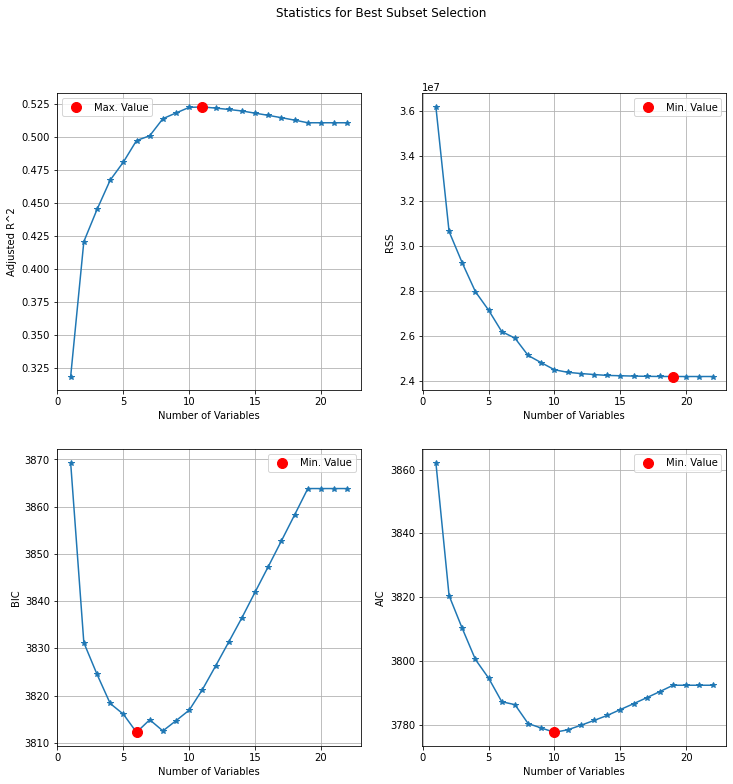

In [305]:
plot_model_test_statistcs(best_models, "Best Subset Selection")

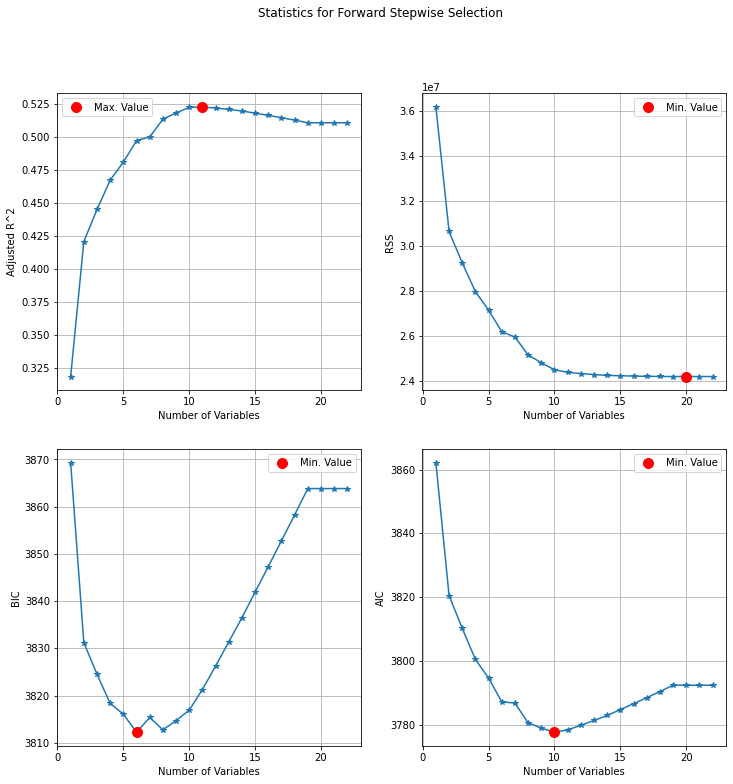

In [306]:
plot_model_test_statistcs(forward_best_models, "Forward Stepwise Selection")

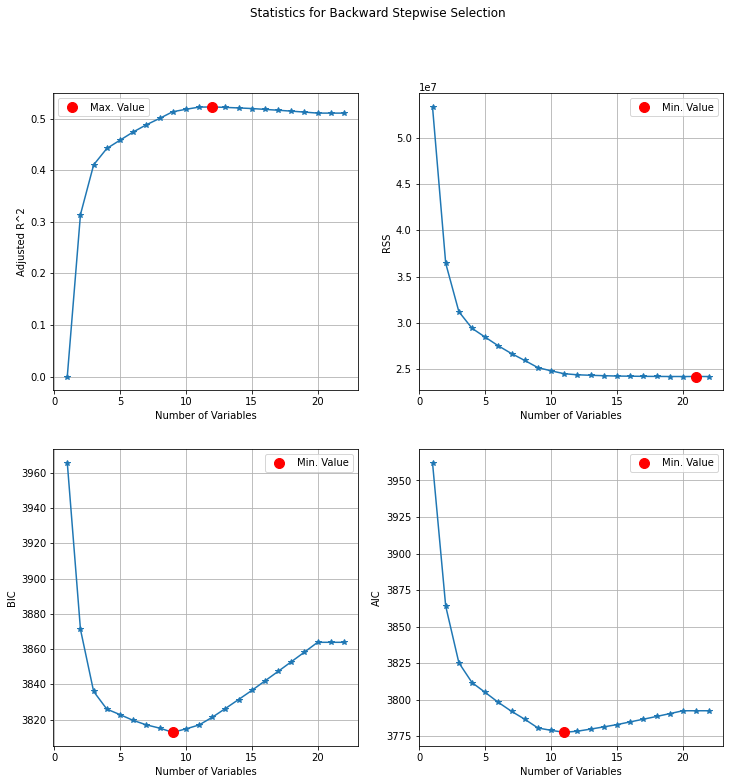

In [307]:
plot_model_test_statistcs(backward_best_models, "Backward Stepwise Selection")

> ## Model Selection through Validation Set

In [22]:
df = get_rdataset("Hitters", "ISLR", cache=True).data

df = df.dropna()
df = df.reset_index().drop(columns=["index"])

df = pd.get_dummies(df, columns=["League", "Division", "NewLeague"], drop_first=True)

In [24]:
df.head()

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    315    81      7    24   38     39     14    3449    835      69    321   
1    479   130     18    66   72     76      3    1624    457      63    224   
2    496   141     20    65   78     37     11    5628   1575     225    828   
3    321    87     10    39   42     30      2     396    101      12     48   
4    594   169      4    74   51     35     11    4408   1133      19    501   

   CRBI  CWalks  PutOuts  Assists  Errors  Salary  League_N  Division_W  \
0   414     375      632       43      10   475.0         1           1   
1   266     263      880       82      14   480.0         0           1   
2   838     354      200       11       3   500.0         1           0   
3    46      33      805       40       4    91.5         1           0   
4   336     194      282      421      25   750.0         0           1   

   NewLeague_N  
0            1  
1            0  
2            1  
3            1  
4            0

In [25]:
index = pd.Series(data=[True,False]).sample(len(df), replace=True, random_state=10).to_numpy()

train = df.loc[index]
test = df.loc[~index]

In [26]:
test

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  \
0      315    81      7    24   38     39     14    3449    835      69   
1      479   130     18    66   72     76      3    1624    457      63   
3      321    87     10    39   42     30      2     396    101      12   
5      185    37      1    23    8     21      2     214     42       1   
6      298    73      0    24   24      7      3     509    108       0   
..     ...   ...    ...   ...  ...    ...    ...     ...    ...     ...   
256    408   117     11    66   41     34      1     408    117      11   
258    497   127      7    65   48     37      5    2703    806      32   
259    492   136      5    76   50     94     12    5511   1511      39   
261    573   144      9    85   60     78      8    3198    857      97   
262    631   170      9    77   44     31     11    4908   1457      30   

     CRuns  CRBI  CWalks  PutOuts  Assists  Errors  Salary  League_N  \
0      321   414     375      632       43      10   475.0         1   
1      224   266     263      880       82      14   480.0         0   
3       48    46      33      805       40       4    91.5         1   
5       30     9      24       76      127       7    70.0         1   
6       41    37      12      121      283       9   100.0         0   
..     ...   ...     ...      ...      ...     ...     ...       ...   
256     66    41      34      942       72      11   120.0         1   
258    379   311     138      325        9       3   700.0         1   
259    897   451     875      313      381      20   875.0         0   
261    470   420     332     1314      131      12   960.0         0   
262    775   357     249      408        4       3  1000.0         0   

     Division_W  NewLeague_N  
0             1            1  
1             1            0  
3             0            1  
5             0            0  
6             1            0  
..          ...          ...  
256           1            1  
258           0            1  
259           0            0  
261           0            0  
262           1            0  

[128 rows x 20 columns]

In [30]:
def standardization(x):
    return (x-x.mean())/x.std()

In [69]:
def bss(data, y, start = 1, p=None):
    models = pd.DataFrame(columns=["model", "rss", "columns"])
    
    if p == None or p > len(data.columns):
        p = len(data.columns)
    
    try:
        for k in range(start, p+1):
            tic = time()
            
            best_ssr = float("inf")
            best_model = None
            for comb in combinations(data.columns, k):
                #X = add_constant(data[list(comb)])
                #model = sm.OLS(y, X).fit()
                
                X = data[list(comb)]
                model = LinearRegression().fit(X, y)
                rss = ((y.to_numpy() - model.predict(X))**2).sum()
                
                if best_model == None:
                    best_model = model
                    best_ssr = rss
                elif rss < best_ssr:
                    best_model = model
                    best_ssr = rss

            best_in_train = {
                            "model" : best_model,
                            "rss" : best_ssr,
                            #"columns": list(best_model.params.index.difference(["const"]))
                            "columns" : best_model.feature_names_in_
                        }              

            models.loc[k] = best_in_train
            toc = time()

            print(k, "-->", toc-tic)
    except KeyboardInterrupt:
        return models
    return models

In [10]:
X_train, y_train = train.drop(columns=["Salary"]), train.Salary
X_test, y_test = test.drop(columns=["Salary"]), test.Salary

In [220]:
best_models = bss(X_train, y_train)

1 --> 0.09052801132202148
2 --> 0.4819943904876709
3 --> 2.742037057876587
4 --> 11.864531517028809
5 --> 33.4277925491333
6 --> 79.68674325942993
7 --> 152.766028881073
8 --> 227.76193523406982
9 --> 275.06241250038147
10 --> 278.74590611457825
11 --> 229.99511003494263
12 --> 154.01873540878296
13 --> 83.7783567905426
14 --> 36.544899463653564
15 --> 12.050204753875732
16 --> 3.065443515777588
17 --> 0.5880932807922363
18 --> 0.0610048770904541
19 --> 0.004999876022338867


In [234]:
os.makedirs("cap5/bss_cv", exist_ok=True)
for i in best_models.index:
    m = best_models.loc[i, "model"]
    dump(m, f"cap5/bss_cv/model_{i}.P")

In [12]:
best_models = pd.DataFrame(columns=["model", "rss", "columns"])
for file in os.listdir("cap5/bss_cv"):
    if ".P" in file:
        m = load(f"cap5/bss_cv/{file}")
        columns = m.feature_names_in_
        rss = ((y_train.to_numpy() - m.predict(X_train[columns]))**2).sum()
        row = { "model":m,
                  "rss":rss,
                  "columns":columns
              }
        best_models.loc[len(columns)]=row
    
    

In [228]:
best_models

model           rss  \
1   LinearRegression()  2.472087e+07   
2   LinearRegression()  2.165398e+07   
3   LinearRegression()  2.059005e+07   
4   LinearRegression()  1.935898e+07   
5   LinearRegression()  1.849674e+07   
6   LinearRegression()  1.825608e+07   
7   LinearRegression()  1.726567e+07   
8   LinearRegression()  1.691913e+07   
9   LinearRegression()  1.664504e+07   
10  LinearRegression()  1.639668e+07   
11  LinearRegression()  1.607107e+07   
12  LinearRegression()  1.601658e+07   
13  LinearRegression()  1.597085e+07   
14  LinearRegression()  1.594545e+07   
15  LinearRegression()  1.592433e+07   
16  LinearRegression()  1.591110e+07   
17  LinearRegression()  1.590889e+07   
18  LinearRegression()  1.590842e+07   
19  LinearRegression()  1.590839e+07   

                                              columns  
1                                             [CRuns]  
2                                    [CRuns, PutOuts]  
3                            [CAtBat, CHits, PutOuts]  
4                [CAtBat, CHits, PutOuts, Division_W]  
5         [Walks, CAtBat, CHits, PutOuts, Division_W]  
6   [Walks, CAtBat, CHits, CRuns, PutOuts, Divisio...  
7   [AtBat, Hits, Walks, CRuns, CWalks, PutOuts, D...  
8   [AtBat, Hits, Walks, CRuns, CWalks, PutOuts, E...  
9   [AtBat, Hits, Walks, CAtBat, CRuns, CWalks, Pu...  
10  [AtBat, Hits, Walks, CAtBat, CRuns, CWalks, Pu...  
11  [AtBat, Hits, RBI, Walks, CAtBat, CRuns, CWalk...  
12  [AtBat, Hits, Runs, RBI, Walks, CAtBat, CRuns,...  
13  [AtBat, Hits, Runs, RBI, Walks, CAtBat, CRuns,...  
14  [AtBat, Hits, Runs, RBI, Walks, CAtBat, CHmRun...  
15  [AtBat, Hits, Runs, RBI, Walks, CAtBat, CHmRun...  
16  [AtBat, Hits, Runs, RBI, Walks, Years, CAtBat,...  
17  [AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...  
18  [AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...  
19  [AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...

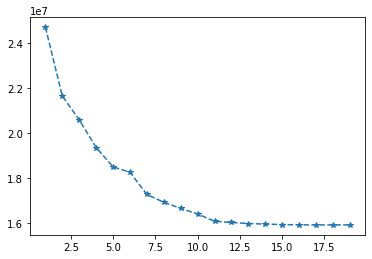

In [15]:
plt.plot(best_models.rss, "--*")

In [16]:
def MSE(y, pred):
    return ((y-pred)**2).mean()

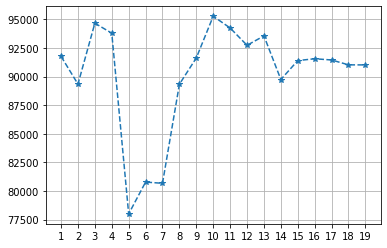

In [17]:
error = []
for i in best_models.index:
    model = best_models.loc[i, "model"]
    columns = best_models.loc[i, "columns"]
    
    #X = add_constant(X_test[columns])
    X = X_test[columns]
    pred = model.predict(X)
    
    error.append(MSE(y_test.to_numpy(), pred))
plt.plot(range(1, len(error)+1), error, "--*")
plt.xticks(range(1, len(error)+1))
plt.grid()
plt.show()

In [18]:
model = best_models.loc[5, "model"]
model.feature_names_in_

array(['Walks', 'CAtBat', 'CHits', 'PutOuts', 'Division_W'], dtype=object)

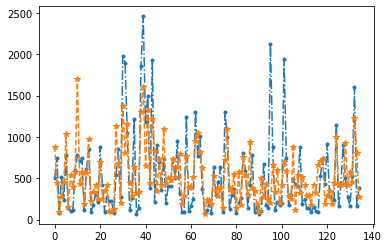

In [227]:
i=5
model = best_models.loc[i,"model"]
columns = best_models.loc[i, "columns"]
plt.plot(y_train.to_numpy(), ".-.")
plt.plot(model.predict(X_train[columns]), "--*")

Model with best results applying it on test data is the one with 5 variables.

In [28]:
best_all_data = bss(df.drop(columns=["Salary"]), df.Salary)

1 --> 0.08903121948242188
2 --> 0.44808411598205566
3 --> 3.1811132431030273
4 --> 11.665816068649292
5 --> 38.970112800598145
6 --> 72.73100280761719
7 --> 137.9259979724884
8 --> 207.61453914642334
9 --> 257.5070126056671
10 --> 259.3480010032654
11 --> 214.06900238990784
12 --> 144.17100048065186
13 --> 78.35851907730103
14 --> 33.713998317718506
15 --> 11.37400221824646
16 --> 2.8929970264434814
17 --> 0.5130012035369873
18 --> 0.05899953842163086
19 --> 0.005000114440917969


<AxesSubplot:>

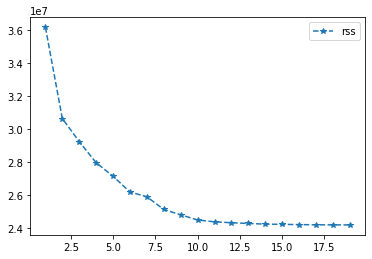

In [31]:
best_all_data.plot(y=["rss"], marker="*", ls="--")

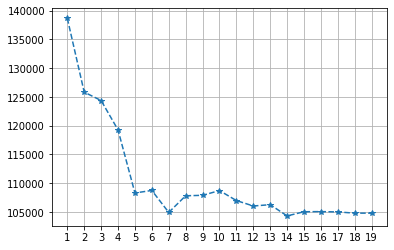

In [32]:
error = []
for i in best_models.index:
    model = best_models.loc[i, "model"]
    columns = best_models.loc[i, "columns"]
    
    #X = add_constant(X_test[columns])
    X = df[columns]
    pred = model.predict(X)
    
    error.append(MSE(df.Salary.to_numpy(), pred))
plt.plot(range(1, len(error)+1), error, "--*")
plt.xticks(range(1, len(error)+1))
plt.grid()
plt.show()

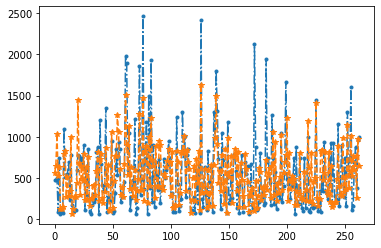

In [33]:
i=5
model = best_all_data.loc[i,"model"]
columns = best_all_data.loc[i, "columns"]
plt.plot(df.Salary.to_numpy(), ".-.")
plt.plot(model.predict(df[columns]), "--*")

In [37]:
print(best_models.loc[5, "columns"],
      best_all_data.loc[5, "columns"],
      sep="\n")

['Walks' 'CAtBat' 'CHits' 'PutOuts' 'Division_W']
['AtBat' 'Hits' 'CRBI' 'PutOuts' 'Division_W']


In [38]:
print(best_all_data.loc[10, "columns"])

['AtBat' 'Hits' 'Walks' 'CAtBat' 'CRuns' 'CRBI' 'CWalks' 'PutOuts'
 'Assists' 'Division_W']


> ## Model Selection through Cross-Validation

In [39]:
df = get_rdataset("Hitters", "ISLR", cache=True).data

df = df.dropna()
df = df.reset_index().drop(columns=["index"])

df = pd.get_dummies(df, columns=["League", "Division", "NewLeague"], drop_first=True)

In [40]:
df.head()

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    315    81      7    24   38     39     14    3449    835      69    321   
1    479   130     18    66   72     76      3    1624    457      63    224   
2    496   141     20    65   78     37     11    5628   1575     225    828   
3    321    87     10    39   42     30      2     396    101      12     48   
4    594   169      4    74   51     35     11    4408   1133      19    501   

   CRBI  CWalks  PutOuts  Assists  Errors  Salary  League_N  Division_W  \
0   414     375      632       43      10   475.0         1           1   
1   266     263      880       82      14   480.0         0           1   
2   838     354      200       11       3   500.0         1           0   
3    46      33      805       40       4    91.5         1           0   
4   336     194      282      421      25   750.0         0           1   

   NewLeague_N  
0            1  
1            0  
2            1  
3            1  
4            0

In [41]:
df.shape

(263, 20)

In [94]:
def cv_folds(X, y, k=10):
    
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    
    all_error = []
    for i in range(len(X_folds)):
        tic = time()
        X_test, y_test = X_folds[i], y_folds[i]
        
        train_index = X.index.difference(X_test.index)
        X_train, y_train = X.loc[train_index], y.loc[train_index]
        
        best_models = bss(X_train, y_train)
        
        local_error = []
        for model in best_models.model:
            columns = model.feature_names_in_
            pred = model.predict(X_test[columns])
            local_error.append(MSE(y_test.to_numpy(), pred))
    
        all_error.append(local_error)
        toc = time()
        print("=============")
        print("Tic:", i, "-->", toc-tic)
        print("=============")
    
    return all_error
        

In [96]:
all_errors = cv_folds(df.drop(columns="Salary"), df.Salary)

1 --> 0.0713813304901123
2 --> 0.4077920913696289
3 --> 2.491219997406006
4 --> 9.329572677612305
5 --> 27.46736478805542
6 --> 64.61178994178772
7 --> 121.36980366706848
8 --> 184.06905603408813
9 --> 231.75036311149597
10 --> 232.22302436828613
11 --> 190.3938226699829
12 --> 134.23039937019348
13 --> 76.9586763381958
14 --> 33.24060392379761
15 --> 11.20182490348816
16 --> 2.8432846069335938
17 --> 0.5121095180511475
18 --> 0.0583035945892334
19 --> 0.002154827117919922
Tic: 0 --> 1323.3108794689178
1 --> 0.042198896408081055
2 --> 0.42154836654663086
3 --> 2.442319393157959
4 --> 10.0587637424469
5 --> 30.023428440093994
6 --> 71.87637090682983
7 --> 133.45667839050293
8 --> 201.0241823196411
9 --> 228.52257251739502
10 --> 230.90871334075928
11 --> 201.04802775382996
12 --> 128.09365272521973
13 --> 69.89583015441895
14 --> 30.15575885772705
15 --> 10.278000831604004
16 --> 2.5451295375823975
17 --> 0.4704587459564209
18 --> 0.05337929725646973
19 --> 0.01565861701965332
Tic: 1 --

In [97]:
np.savetxt("cap5/errors.csv", all_errors)

In [100]:
all_errors = np.array(all_errors)

In [111]:
all_errors.mean(axis=0)

array([149077.41813984, 131847.48398374, 137281.84288112, 128359.37253921,
       128638.96971658, 118400.65835462, 120631.49101451, 112612.64671764,
       113784.00221726, 111497.27443842, 110909.58183106, 113307.69811502,
       115054.44370503, 114870.9254033 , 116400.46636873, 116168.4850355 ,
       115939.23507277, 116263.9270262 , 116599.0136738 ])

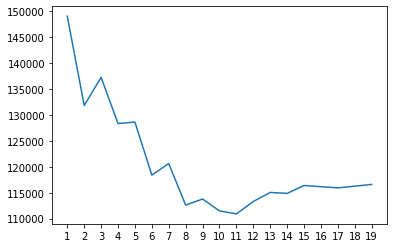

In [114]:
plt.plot(range(1,all_errors.shape[1]+1),all_errors.mean(axis=0))
plt.xticks(range(1,all_errors.shape[1]+1))
plt.show()

- Cross Validation method selects 11 variable model as the best model

## *Ridge Regression*

In [2]:
from sklearn.linear_model import Ridge, Lasso


In [3]:
df = df = get_rdataset("Hitters", "ISLR", cache=True).data

In [4]:
df.head()

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
-Andy Allanson       293    66      1    30   29     14      1     293     66   
-Alan Ashby          315    81      7    24   38     39     14    3449    835   
-Alvin Davis         479   130     18    66   72     76      3    1624    457   
-Andre Dawson        496   141     20    65   78     37     11    5628   1575   
-Andres Galarraga    321    87     10    39   42     30      2     396    101   

                   CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  \
-Andy Allanson          1     30    29      14      A        E      446   
-Alan Ashby            69    321   414     375      N        W      632   
-Alvin Davis           63    224   266     263      A        W      880   
-Andre Dawson         225    828   838     354      N        E      200   
-Andres Galarraga      12     48    46      33      N        E      805   

                   Assists  Errors  Salary NewLeague  
-Andy Allanson          33      20     NaN         A  
-Alan Ashby             43      10   475.0         N  
-Alvin Davis            82      14   480.0         A  
-Andre Dawson           11       3   500.0         N  
-Andres Galarraga       40       4    91.5         N

In [5]:
df = df.dropna()

In [6]:
df = pd.get_dummies(df, columns=["League", "Division", "NewLeague"], drop_first=True)

In [7]:
df.head()

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
-Alan Ashby          315    81      7    24   38     39     14    3449    835   
-Alvin Davis         479   130     18    66   72     76      3    1624    457   
-Andre Dawson        496   141     20    65   78     37     11    5628   1575   
-Andres Galarraga    321    87     10    39   42     30      2     396    101   
-Alfredo Griffin     594   169      4    74   51     35     11    4408   1133   

                   CHmRun  CRuns  CRBI  CWalks  PutOuts  Assists  Errors  \
-Alan Ashby            69    321   414     375      632       43      10   
-Alvin Davis           63    224   266     263      880       82      14   
-Andre Dawson         225    828   838     354      200       11       3   
-Andres Galarraga      12     48    46      33      805       40       4   
-Alfredo Griffin       19    501   336     194      282      421      25   

                   Salary  League_N  Division_W  NewLeague_N  
-Alan Ashby         475.0         1           1            1  
-Alvin Davis        480.0         0           1            0  
-Andre Dawson       500.0         1           0            1  
-Andres Galarraga    91.5         1           0            1  
-Alfredo Griffin    750.0         0           1            0

In [8]:
X = add_constant(df.drop(columns=["Salary"]))
y = df.Salary

In [9]:
lambdas = 10**np.linspace(10, -1, num=100)

In [10]:
models = [Ridge(alpha=l).fit(X,y) for l in lambdas]

In [16]:
pd.DataFrame(  data= dict(zip(models[10].feature_names_in_, models[10].coef_) ), index=[0] )

const     AtBat      Hits     HmRun      Runs       RBI     Walks  \
0    0.0  0.007103  0.002479  0.000349  0.001377  0.001364  0.001138   

      Years    CAtBat     CHits  CHmRun     CRuns      CRBI    CWalks  \
0  0.000057  0.060222  0.019455   0.003  0.010835  0.011319  0.006785   

    PutOuts  Assists    Errors      League_N  Division_W   NewLeague_N  
0  0.011653  0.00064  0.000019 -4.009453e-07   -0.000014 -7.348733e-08

In [21]:
np.sqrt((models[10].coef_**2).sum())

0.06711016640958635

In [12]:
pd.DataFrame(  data= dict(zip(models[60].feature_names_in_, models[60].coef_) ), index=[0] )

const     AtBat      Hits     HmRun      Runs       RBI     Walks  \
0    0.0 -1.984211  6.689164  0.588582 -0.931502  0.411236  5.475404   

      Years    CAtBat     CHits   CHmRun     CRuns      CRBI    CWalks  \
0 -0.454073 -0.211379  0.261568  0.03674  1.430218  0.702162 -0.704847   

    PutOuts   Assists    Errors  League_N  Division_W  NewLeague_N  
0  0.294967  0.363228 -2.247564  1.229091   -3.264301     0.884849

In [25]:
np.sqrt((models[60].coef_**2).sum())

10.080726971875702

In [13]:
train = df.sample(frac=0.5)
test = df.loc[ df.index.difference(train.index) ]

In [14]:
X_train, y_train = train.drop(columns=["Salary"]), train.Salary
model = Ridge(alpha=4).fit(X_train, y_train)

X_test, y_test = test.drop(columns=["Salary"]), test.Salary
pred = model.predict(X_test)
mse = np.mean( (y_test - pred)**2 )
print(mse)

111528.26489799944


In [27]:
X_train, y_train = train.drop(columns=["Salary"]), train.Salary
model = LinearRegression().fit(X_train, y_train)

X_test, y_test = test.drop(columns=["Salary"]), test.Salary
pred = model.predict(X_test)
mse = np.mean( (y_test - pred)**2 )
print(mse)

111627.45447235777


In [26]:
X_train, y_train = train.drop(columns=["Salary"]), train.Salary
X_test, y_test = test.drop(columns=["Salary"]), test.Salary

pred = y_train.mean()
mse = np.mean( (y_test - pred)**2 )
print(mse)

160730.57640191398


In [32]:
X_train, y_train = train.drop(columns=["Salary"]), train.Salary
model = Ridge(alpha=1e15).fit(X_train, y_train)

X_test, y_test = test.drop(columns=["Salary"]), test.Salary
pred = model.predict(X_test)
mse = np.mean( (y_test - pred)**2 )
print(mse)

160730.48638518364


In [33]:
from sklearn.linear_model import RidgeCV, LassoCV

In [109]:
m = RidgeCV(alphas=lambdas, cv=10).fit(X_train, y_train)
m.alpha_

599484.2503189408

In [110]:
pred = m.predict(X_test)
mse = np.mean( (y_test - pred)**2 )
print(mse)

106235.44827593052


In [111]:
pd.DataFrame(  data= dict(zip(m.feature_names_in_, m.coef_) ), index=[0] )

AtBat      Hits     HmRun      Runs       RBI     Walks     Years  \
0  0.469546  0.396506  0.042141  0.202924  0.182244  0.257255 -0.004644   

     CAtBat    CHits    CHmRun     CRuns      CRBI    CWalks   PutOuts  \
0 -0.320175  0.91351  0.266706  0.476333  0.780478 -0.331146  0.419244   

    Assists    Errors  League_N  Division_W  NewLeague_N  
0  0.106612 -0.024265 -0.000277   -0.008138    -0.000719

## *Lasso Regression*

In [118]:
m = LassoCV(n_alphas=1000, cv=10).fit(X_train, y_train)
m.alpha_

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.261e+05, tolerance: 3.264e+03
  model = cd_fast.enet_coordinate_descent(


536.9305523481403

In [119]:
pred = m.predict(X_test)
mse = np.mean( (y_test - pred)**2 )
print(mse)

113878.3221893887


In [120]:
pd.DataFrame(  data= dict(zip(m.feature_names_in_, m.coef_) ), index=[0] )

AtBat      Hits  HmRun  Runs  RBI     Walks  Years    CAtBat     CHits  \
0 -0.099573  1.874613    0.0   0.0  0.0  2.562001    0.0 -0.499323  1.490982   

     CHmRun     CRuns      CRBI    CWalks  PutOuts   Assists  Errors  \
0  0.357548  0.451329  1.019194 -0.515771    0.392  0.177502    -0.0   

   League_N  Division_W  NewLeague_N  
0       0.0        -0.0          0.0

## *Principal Componentes Regression*

In [123]:
df = get_rdataset("Hitters", "ISLR", cache=True).data
df = df.dropna()
df = pd.get_dummies(df, columns=["League", "Division", "NewLeague"], drop_first=True)

In [124]:
df.head()

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
-Alan Ashby          315    81      7    24   38     39     14    3449    835   
-Alvin Davis         479   130     18    66   72     76      3    1624    457   
-Andre Dawson        496   141     20    65   78     37     11    5628   1575   
-Andres Galarraga    321    87     10    39   42     30      2     396    101   
-Alfredo Griffin     594   169      4    74   51     35     11    4408   1133   

                   CHmRun  CRuns  CRBI  CWalks  PutOuts  Assists  Errors  \
-Alan Ashby            69    321   414     375      632       43      10   
-Alvin Davis           63    224   266     263      880       82      14   
-Andre Dawson         225    828   838     354      200       11       3   
-Andres Galarraga      12     48    46      33      805       40       4   
-Alfredo Griffin       19    501   336     194      282      421      25   

                   Salary  League_N  Division_W  NewLeague_N  
-Alan Ashby         475.0         1           1            1  
-Alvin Davis        480.0         0           1            0  
-Andre Dawson       500.0         1           0            1  
-Andres Galarraga    91.5         1           0            1  
-Alfredo Griffin    750.0         0           1            0

In [125]:
X, y = df.drop(columns=["Salary"]), df.Salary

In [135]:
from sklearn.preprocessing import scale

In [137]:
pca = PCA()
X_norm = pca.fit_transform(scale(df))

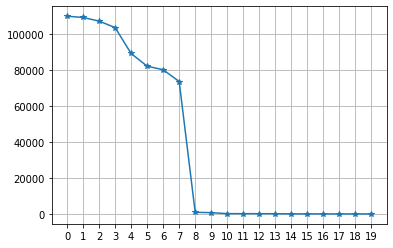

In [142]:
lm = LinearRegression()
cv = KFold(n_splits=10, shuffle=True)

mse = []

for i in np.arange(1, len(df.columns)+1):
    score = -cross_val_score(lm, X_norm[:,:i], y=y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(mse, '-*')
plt.xticks(range(len(df.columns)))
plt.grid()

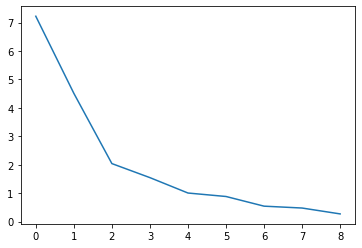

In [180]:
plt.plot(pca.explained_variance_[:9])

In [161]:
norm_X_train = scale(X_train)
norm_y_train = scale(y_train)

In [163]:
pca = pca.fit(norm_X_train, norm_y_train)

In [179]:
m = LinearRegression().fit(X_train[X_train.columns[:9]], y_train)
pred = m.predict(X_test[X_test.columns[:9]])
mse = np.sqrt( np.mean( (pred - y_test)**2 ) )
print(mse)

331.0688118578547


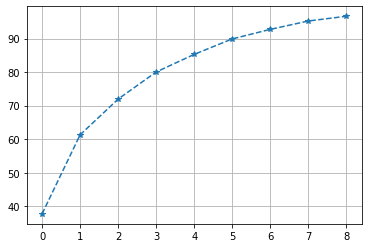

In [190]:
plt.plot(np.cumsum(pca.explained_variance_ratio_[:9]*100), "--*")
plt.xticks(range(9))
plt.grid()
plt.show()

## *Partial Least Squares*

In [191]:
from sklearn.cross_decomposition import PLSRegression

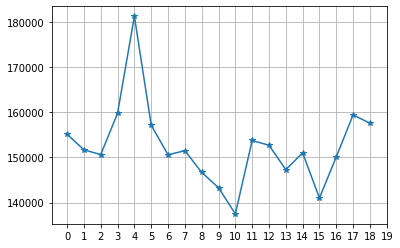

In [204]:
cv = KFold(n_splits=10, shuffle=True)

mse = []

for i in np.arange(1, len(df.columns)):
    model = PLSRegression(n_components=i)
    score = -cross_val_score(model, X=X_train, y=y_train, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(mse, '-*')
plt.xticks(range(len(df.columns)))
plt.grid()

In [209]:
model = PLSRegression(n_components=11).fit(X_train, y_train)
pred = model.predict(X_test).flatten()

mse = np.sqrt( ((pred - y_test)**2).mean() )
print(mse)

331.38204512723325


## Applied

In [219]:
np.random.seed(1)

In [220]:
X = np.random.normal(size=100)
noise = np.random.normal(size=100)

In [221]:
b0 = 3
b1 = 2
b2 = -3
b3 = 0.3

Y = b0 + b1 * X + b2 * X**2 + b3 * X**3 + noise

In [222]:
df = pd.DataFrame(data={"Y":Y, "X":X})

In [223]:
for i in range(2,10+1):
    df[f"X{i}"] = df.X**i

In [224]:
df.head()

Y         X        X2        X3        X4         X5         X6  \
0 -0.828182  1.624345  2.638498  4.285832  6.961671  11.308158  18.368354   
1  1.809573 -0.611756  0.374246 -0.228947  0.140060  -0.085683   0.052417   
2  1.466049 -0.528172  0.278965 -0.147342  0.077822  -0.041103   0.021710   
3 -2.376724 -1.072969  1.151262 -1.235268  1.325403  -1.422116   1.525886   
4  1.583551  0.865408  0.748930  0.648130  0.560897   0.485404   0.420073   

          X7         X8         X9         X10  
0  29.836551  48.464863  78.723675  127.874436  
1  -0.032066   0.019617  -0.012001    0.007342  
2  -0.011466   0.006056  -0.003199    0.001689  
3  -1.637228   1.756694  -1.884878    2.022415  
4   0.363534   0.314605   0.272262    0.235617

In [537]:
def bss(data, y, start = 1, p=None):
    models = pd.DataFrame(columns=["model", "rss", "columns"])
    
    if p == None or p > len(data.columns):
        p = len(data.columns)
    
    for k in range(start, p+1):
        tic = time()

        best_ssr = float("inf")
        best_model = None
        for comb in combinations(data.columns, k):
            #X = add_constant(data[list(comb)])
            #model = lm.OLS(y, X).fit()
            X = data[list(comb)]
            model = LinearRegression().fit(X, y)
            
            rss = ((y.to_numpy() - model.predict(X))**2).sum()
            
            if best_model == None:
                best_model = model
                best_ssr = rss
            elif rss < best_ssr:
                best_model = model
                best_ssr = rss

        best_in_train = {
                        "model" : best_model,
                        "rss" : best_ssr,
                        #"columns" : best_model.params.index
                        "columns": best_model.feature_names_in_
                    }              

        models.loc[k] = best_in_train
        toc = time()

        print(k, "-->", toc-tic)
    return models

In [226]:
models = bss( df.drop(columns="Y"), df.Y)

1 --> 0.029491186141967773
2 --> 0.13700032234191895
3 --> 0.3420143127441406
4 --> 0.773029088973999
5 --> 0.9470100402832031
6 --> 0.7229597568511963
7 --> 0.43799901008605957
8 --> 0.171036958694458
9 --> 0.042671918869018555
10 --> 0.006965160369873047


In [227]:
models

model         rss  \
1   <statsmodels.regression.linear_model.Regressio...  726.411627   
2   <statsmodels.regression.linear_model.Regressio...  114.991706   
3   <statsmodels.regression.linear_model.Regressio...   84.811563   
4   <statsmodels.regression.linear_model.Regressio...   79.800246   
5   <statsmodels.regression.linear_model.Regressio...   79.446732   
6   <statsmodels.regression.linear_model.Regressio...   78.626975   
7   <statsmodels.regression.linear_model.Regressio...   77.535196   
8   <statsmodels.regression.linear_model.Regressio...   77.090698   
9   <statsmodels.regression.linear_model.Regressio...   76.851334   
10  <statsmodels.regression.linear_model.Regressio...   76.498124   

                                              columns  
1              Index(['const', 'X2'], dtype='object')  
2         Index(['const', 'X', 'X2'], dtype='object')  
3   Index(['const', 'X', 'X2', 'X3'], dtype='object')  
4   Index(['const', 'X', 'X2', 'X3', 'X6'], dtype=...  
5   Index(['const', 'X', 'X2', 'X3', 'X8', 'X10'],...  
6   Index(['const', 'X', 'X2', 'X5', 'X6', 'X7', '...  
7   Index(['const', 'X', 'X2', 'X3', 'X5', 'X7', '...  
8   Index(['const', 'X', 'X2', 'X3', 'X4', 'X5', '...  
9   Index(['const', 'X', 'X2', 'X3', 'X4', 'X5', '...  
10  Index(['const', 'X', 'X2', 'X3', 'X4', 'X5', '...

In [228]:
models.model.apply(lambda x: x.ssr)

1     726.411627
2     114.991706
3      84.811563
4      79.800246
5      79.446732
6      78.626975
7      77.535196
8      77.090698
9      76.851334
10     76.498124
Name: model, dtype: float64

In [229]:
bic = models.model.apply(lambda x: x.bic)
aic = models.model.apply(lambda x: x.aic)
r2 = models.model.apply(lambda x: x.rsquared_adj)

Text(0.5, 1.0, 'AIC')

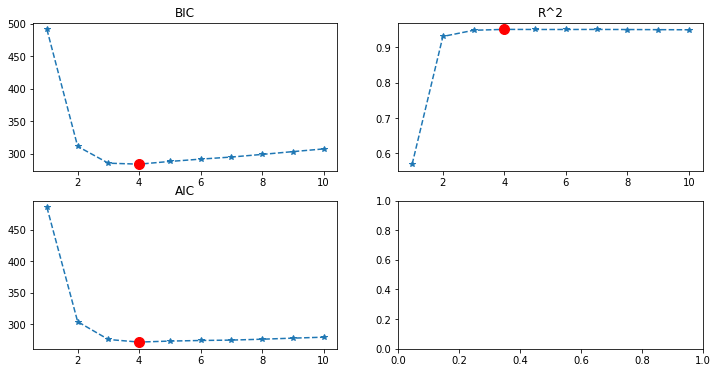

In [230]:
f, ax = plt.subplots(2,2, figsize=(12,6))

ax[0,0].plot(bic, "--*")
ax[0,0].plot(bic[bic==bic.min()], "ro", markersize=10)
ax[0,0].set_title("BIC")

ax[0,1].plot(r2, "--*")
ax[0,1].plot(r2[r2==r2.max()], "ro", markersize=10)
ax[0,1].set_title("R^2")

ax[1,0].plot(aic, "--*")
ax[1,0].plot(aic[aic==aic.min()], "ro", markersize=10)
ax[1,0].set_title("AIC")

According to best subset selection, the number of predictors selected should be 4. All of the statistics agree.

In [231]:
models["columns"].loc[4]

Index(['const', 'X', 'X2', 'X3', 'X6'], dtype='object')

In [232]:
def forward_train_best(data, y, predictor):
    best = None

    for p in data.columns.difference(predictor):
        cols = predictor + [p]
        X = add_constant(data[cols])
        
        model = lm.OLS(y, X).fit()       
        if best == None:
            best = model
        elif model.ssr < best.ssr:
            best = model
        
    best = {
            "model" : best,
            "rss" : best.ssr,
            "cols": model.params.index
            }
    
    return best, list(best["model"].params.index.difference(["const"]))

In [233]:
def forward_bss(data, y, p=None):
    models = pd.DataFrame(columns=["model", "rss", "cols"])
    
    if p == None or p > len(data.columns):
        p = len(data.columns)
    
    predictors = []
    for k in range(1, p+1):
        tic = time()
        (best_in_train, 
         predictors) = forward_train_best(data, y, predictors)
        models.loc[k] = best_in_train
        toc = time()
        
        print(toc-tic)
    return models

In [234]:
models = forward_bss(df.drop(columns="Y"), df.Y)

0.027028799057006836
0.028001785278320312
0.02896881103515625
0.021999835968017578
0.019999027252197266
0.017000436782836914
0.015000104904174805
0.012035608291625977
0.009999752044677734
0.006000041961669922


In [235]:
bic = models.model.apply(lambda x: x.bic)
aic = models.model.apply(lambda x: x.aic)
r2 = models.model.apply(lambda x: x.rsquared_adj)

Text(0.5, 1.0, 'AIC')

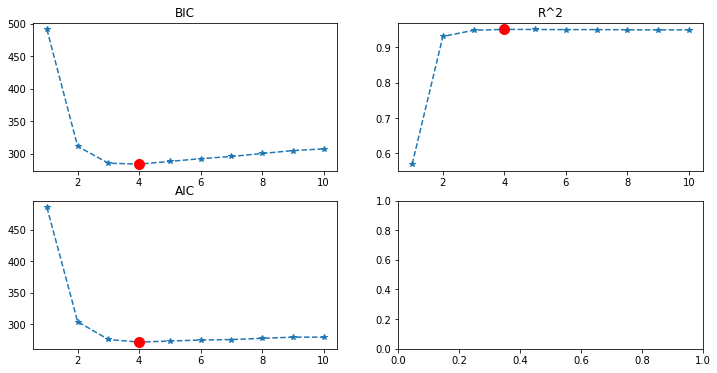

In [237]:
f, ax = plt.subplots(2,2, figsize=(12,6))

ax[0,0].plot(bic, "--*")
ax[0,0].plot(bic[bic==bic.min()], "ro", markersize=10)
ax[0,0].set_title("BIC")

ax[0,1].plot(r2, "--*")
ax[0,1].plot(r2[r2==r2.max()], "ro", markersize=10)
ax[0,1].set_title("R^2")

ax[1,0].plot(aic, "--*")
ax[1,0].plot(aic[aic==aic.min()], "ro", markersize=10)
ax[1,0].set_title("AIC")

As in the previous case, the recomended number of predicts is 4, in all of the statistics

In [238]:
models.loc[4].cols

Index(['const', 'X', 'X2', 'X3', 'X9'], dtype='object')

The columns selected differ from the best subset. Altough the number of predictors is the same, the variables selected do not correspond to the same set

In [239]:
def backward_train_best(data, y, predictors):
    best = None

    for p in predictors:
        cols = predictors.difference([p])
        X = add_constant(data[cols])
        
        model = lm.OLS(y, X).fit()       
        if best == None:
            best = model
        elif model.ssr < best.ssr:
            best = model
        
    best = {
            "model" : best,
            "rss" : best.ssr,
            "cols": model.params.index
            }
    
    return best, best["model"].params.index.difference(["const"])

In [240]:
def backward_bss(data, y, p=None):
    models = pd.DataFrame(columns=["model", "rss","cols"])
    
    if p == None or p > len(data.columns):
        p = len(data.columns)
    
    predictors = data.columns
    for k in range(p, 0, -1):
        tic = time()
        (best_in_train, 
         predictors) = backward_train_best(data, y, predictors)
        models.loc[k] = best_in_train
        toc = time()
        
        print(toc-tic)
    return models

In [241]:
models = backward_bss(df.drop(columns="Y"), df.Y)

0.04781985282897949
0.04699563980102539
0.031002044677734375
0.02400374412536621
0.018999814987182617
0.016965389251708984
0.01100015640258789
0.009000539779663086
0.005999326705932617
0.002999544143676758


In [242]:
bic = models.model.apply(lambda x: x.bic)
aic = models.model.apply(lambda x: x.aic)
r2 = models.model.apply(lambda x: x.rsquared_adj)

Text(0.5, 1.0, 'AIC')

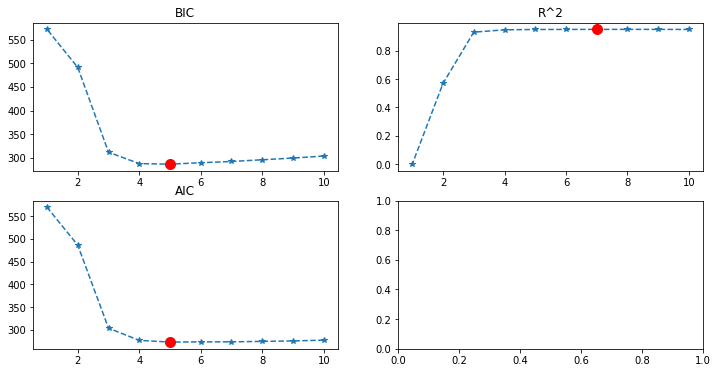

In [243]:
f, ax = plt.subplots(2,2, figsize=(12,6))

ax[0,0].plot(bic, "--*")
ax[0,0].plot(bic[bic==bic.min()], "ro", markersize=10)
ax[0,0].set_title("BIC")

ax[0,1].plot(r2, "--*")
ax[0,1].plot(r2[r2==r2.max()], "ro", markersize=10)
ax[0,1].set_title("R^2")

ax[1,0].plot(aic, "--*")
ax[1,0].plot(aic[aic==aic.min()], "ro", markersize=10)
ax[1,0].set_title("AIC")

This case presents some unexpected results, assigning 5 to 7 predictors to the model. 

In [244]:
models.loc[[5,7]].cols

5    Index(['const', 'X', 'X2', 'X5', 'X6'], dtype=...
7    Index(['const', 'X', 'X2', 'X3', 'X5', 'X6', '...
Name: cols, dtype: object

In [269]:
n = np.linspace(0, 2, 5000)
lambdas = np.logspace(-15,2,2000)

In [270]:
lasso = LassoCV(alphas=lambdas).fit(df.drop(columns="Y"), df.Y)

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1526370468928917, tolerance: 0.08050986926103429
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16377975553308488, tolerance: 0.08050986926103429
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1756774837656394, tolerance: 0.08050986926103429
  model = cd_fast.enet_coordinate_descent_gra

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.134634246322836, tolerance: 0.08050986926103429
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.247688578921444, tolerance: 0.08050986926103429
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.358324218757534, tolerance: 0.08050986926103429
  model = cd_fast.enet_coordinate_descent_gram

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.016973018476044, tolerance: 0.08050986926103429
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.019906157706743, tolerance: 0.08050986926103429
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.022773916045786, tolerance: 0.08050986926103429
  model = cd_fast.enet_coordinate_descent_gram

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.14594275047726, tolerance: 0.08050986926103429
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.14591139305669, tolerance: 0.08050986926103429
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.145879987930968, tolerance: 0.08050986926103429
  model = cd_fast.enet_coordinate_descent_gram(


C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.138301376764772, tolerance: 0.08050986926103429
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.13828529573916, tolerance: 0.08050986926103429
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.138269265553845, tolerance: 0.08050986926103429
  model = cd_fast.enet_coordinate_descent_gram(

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.135279297159673, tolerance: 0.08050986926103429
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.13527287244241, tolerance: 0.08050986926103429
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.13526646784506, tolerance: 0.08050986926103429
  model = cd_fast.enet_coordinate_descent_gram(


C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.182835196647261, tolerance: 0.1602611009735645
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17286060869935227, tolerance: 0.1602611009735645
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2057296179128798, tolerance: 0.1602611009735645
  model = cd_fast.enet_coordinate_descent_gram(
C

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.89950330887525, tolerance: 0.1602611009735645
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.951866789649404, tolerance: 0.1602611009735645
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.003106859766007, tolerance: 0.1602611009735645
  model = cd_fast.enet_coordinate_descent_gram(
C:

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.9012219099465, tolerance: 0.1602611009735645
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.901484972203214, tolerance: 0.1602611009735645
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.901743047692086, tolerance: 0.1602611009735645
  model = cd_fast.enet_coordinate_descent_gram(
C:\

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.911989115263047, tolerance: 0.1602611009735645
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.91198008384135, tolerance: 0.1602611009735645
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.911971079816336, tolerance: 0.1602611009735645
  model = cd_fast.enet_coordinate_descent_gram(
C:

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.910596670975156, tolerance: 0.1602611009735645
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.910594938002603, tolerance: 0.1602611009735645
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.910593216870225, tolerance: 0.1602611009735645
  model = cd_fast.enet_coordinate_descent_gram(
C

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.910373174184365, tolerance: 0.1602611009735645
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.910372934567512, tolerance: 0.1602611009735645
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.91037269627934, tolerance: 0.1602611009735645
  model = cd_fast.enet_coordinate_descent_gram(
C:

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3926017990508157, tolerance: 0.16049713008445748
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.36515724663559723, tolerance: 0.16049713008445748
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.35437467527746946, tolerance: 0.16049713008445748
  model = cd_fast.enet_coordinate_descent_gr

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.908800233607508, tolerance: 0.16049713008445748
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.91218289674295, tolerance: 0.16049713008445748
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.915503054014657, tolerance: 0.16049713008445748
  model = cd_fast.enet_coordinate_descent_gram(

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.084294991758114, tolerance: 0.16049713008445748
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.084271020910894, tolerance: 0.16049713008445748
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.084246905413963, tolerance: 0.16049713008445748
  model = cd_fast.enet_coordinate_descent_gram

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.07937024802071, tolerance: 0.16049713008445748
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.079352485085558, tolerance: 0.16049713008445748
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.079334786820294, tolerance: 0.16049713008445748
  model = cd_fast.enet_coordinate_descent_gram(

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.076452117244365, tolerance: 0.16049713008445748
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.076445659312018, tolerance: 0.16049713008445748
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.076439227157447, tolerance: 0.16049713008445748
  model = cd_fast.enet_coordinate_descent_gram

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.07538354036514, tolerance: 0.16049713008445748
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.07538134715413, tolerance: 0.16049713008445748
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.07537916261849, tolerance: 0.16049713008445748
  model = cd_fast.enet_coordinate_descent_gram(
C

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.370729433413324, tolerance: 0.11681105225001459
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.306990419518186, tolerance: 0.11681105225001459
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.24300873918397, tolerance: 0.11681105225001459
  model = cd_fast.enet_coordinate_descent_gram(
C:

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.893183171276593, tolerance: 0.11681105225001459
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.910461417261246, tolerance: 0.11681105225001459
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.92736803882815, tolerance: 0.11681105225001459
  model = cd_fast.enet_coordinate_descent_gram(

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.624876668782182, tolerance: 0.11681105225001459
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.62459462988096, tolerance: 0.11681105225001459
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.62431070907533, tolerance: 0.11681105225001459
  model = cd_fast.enet_coordinate_descent_gram(


C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.52803626626644, tolerance: 0.11681105225001459
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.527734358340954, tolerance: 0.11681105225001459
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.527432788091428, tolerance: 0.11681105225001459
  model = cd_fast.enet_coordinate_descent_gram(

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.452452592858986, tolerance: 0.11681105225001459
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.452246087048838, tolerance: 0.11681105225001459
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.452039860794834, tolerance: 0.11681105225001459
  model = cd_fast.enet_coordinate_descent_gram

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.40115133873095, tolerance: 0.11681105225001459
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.401016001382555, tolerance: 0.11681105225001459
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.400880852561876, tolerance: 0.11681105225001459
  model = cd_fast.enet_coordinate_descent_gram(

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2805730675045695, tolerance: 0.1594274436595235
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2711233976628051, tolerance: 0.1594274436595235
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2618267165560368, tolerance: 0.1594274436595235
  model = cd_fast.enet_coordinate_descent_gram(
C

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.87150720228869, tolerance: 0.1594274436595235
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.88985924188003, tolerance: 0.1594274436595235
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.908039827750695, tolerance: 0.1594274436595235
  model = cd_fast.enet_coordinate_descent_gram(
C:\

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.403668596440195, tolerance: 0.1594274436595235
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.403906521727656, tolerance: 0.1594274436595235
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.404140655558702, tolerance: 0.1594274436595235
  model = cd_fast.enet_coordinate_descent_gram(
C

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.41843669396168, tolerance: 0.1594274436595235
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.41843827198022, tolerance: 0.1594274436595235
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.41843982279647, tolerance: 0.1594274436595235
  model = cd_fast.enet_coordinate_descent_gram(
C:\U

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.418524492150627, tolerance: 0.1594274436595235
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.418524485616942, tolerance: 0.1594274436595235
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.418524478620952, tolerance: 0.1594274436595235
  model = cd_fast.enet_coordinate_descent_gram(
C

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.633e+00, tolerance: 1.705e-01
  model = cd_fast.enet_coordinate_descent(


Text(0.5, 0, 'Lambda')

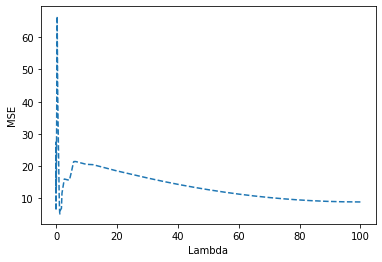

In [271]:
plt.plot( lasso.alphas_ , lasso.mse_path_.mean(axis=1), "--" )
plt.ylabel("MSE")
plt.xlabel("Lambda")

In [273]:
pd.DataFrame(  data= dict(zip(lasso.feature_names_in_, lasso.coef_) ), index=[0] )

X   X2   X3   X4   X5        X6       X7        X8        X9       X10
0  0.0 -0.0  0.0 -0.0  0.0 -0.253648  0.09901 -0.008917 -0.012597  0.007852

In [274]:
lasso.alpha_

1.2692634549682567

In [275]:
df["Y2"] = b0 + 0.34*X**7 + noise

In [276]:
bss_models = bss( df.drop(columns=["Y","Y2"]), df.Y2)

1 --> 0.0314028263092041
2 --> 0.13503003120422363
3 --> 0.33800578117370605
4 --> 0.8070039749145508
5 --> 0.9259603023529053
6 --> 0.7200005054473877
7 --> 0.43900036811828613
8 --> 0.22500038146972656
9 --> 0.05499887466430664
10 --> 0.008000373840332031


In [277]:
bic = bss_models.model.apply(lambda x: x.bic)
aic = bss_models.model.apply(lambda x: x.aic)
r2 = bss_models.model.apply(lambda x: x.rsquared_adj)

Text(0.5, 1.0, 'AIC')

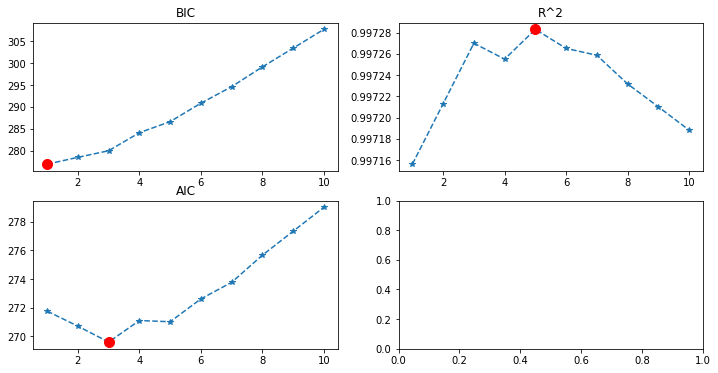

In [278]:
f, ax = plt.subplots(2,2, figsize=(12,6))

ax[0,0].plot(bic, "--*")
ax[0,0].plot(bic[bic==bic.min()], "ro", markersize=10)
ax[0,0].set_title("BIC")

ax[0,1].plot(r2, "--*")
ax[0,1].plot(r2[r2==r2.max()], "ro", markersize=10)
ax[0,1].set_title("R^2")

ax[1,0].plot(aic, "--*")
ax[1,0].plot(aic[aic==aic.min()], "ro", markersize=10)
ax[1,0].set_title("AIC")

<AxesSubplot:>

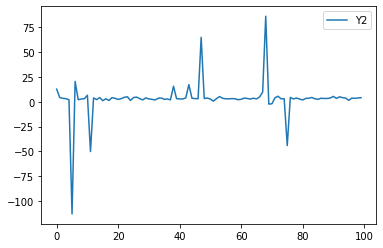

In [279]:
df.plot(y="Y2")

In [307]:
lambdas = np.logspace(-1,9,2000)

In [308]:
lasso = LassoCV(alphas=lambdas).fit(df.drop(columns=["Y","Y2"]), df.Y2)

C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.026e+01, tolerance: 3.026e+00
  model = cd_fast.enet_coordinate_descent(


In [309]:
pd.DataFrame(  data= dict(zip(lasso.feature_names_in_, lasso.coef_) ), index=[0] )

X   X2   X3   X4        X5        X6        X7   X8        X9       X10
0 -0.0 -0.0  0.0 -0.0  0.132113 -0.016464  0.266038 -0.0  0.010504  0.001123

In [310]:
lasso.alpha_

0.15491556222861178

## ====================
## == == == == == == == ==
## ===== Exercicio 9 =====
## == == == == == == == ==
## ====================

In [315]:
df = get_rdataset("College", "ISLR", cache=True).data

In [316]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 777 entries, Abilene Christian University to York College of Pennsylvania
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Private      777 non-null    object 
 1   Apps         777 non-null    int64  
 2   Accept       777 non-null    int64  
 3   Enroll       777 non-null    int64  
 4   Top10perc    777 non-null    int64  
 5   Top25perc    777 non-null    int64  
 6   F.Undergrad  777 non-null    int64  
 7   P.Undergrad  777 non-null    int64  
 8   Outstate     777 non-null    int64  
 9   Room.Board   777 non-null    int64  
 10  Books        777 non-null    int64  
 11  Personal     777 non-null    int64  
 12  PhD          777 non-null    int64  
 13  Terminal     777 non-null    int64  
 14  S.F.Ratio    777 non-null    float64
 15  perc.alumni  777 non-null    int64  
 16  Expend       777 non-null    int64  
 17  Grad.Rate    777 non-null    int64  
dtypes: 

In [330]:
df.describe()

Apps        Accept       Enroll   Top10perc   Top25perc  \
count    777.000000    777.000000   777.000000  777.000000  777.000000   
mean    3001.638353   2018.804376   779.972973   27.558559   55.796654   
std     3870.201484   2451.113971   929.176190   17.640364   19.804778   
min       81.000000     72.000000    35.000000    1.000000    9.000000   
25%      776.000000    604.000000   242.000000   15.000000   41.000000   
50%     1558.000000   1110.000000   434.000000   23.000000   54.000000   
75%     3624.000000   2424.000000   902.000000   35.000000   69.000000   
max    48094.000000  26330.000000  6392.000000   96.000000  100.000000   

        F.Undergrad   P.Undergrad      Outstate   Room.Board        Books  \
count    777.000000    777.000000    777.000000   777.000000   777.000000   
mean    3699.907336    855.298584  10440.669241  4357.526384   549.380952   
std     4850.420531   1522.431887   4023.016484  1096.696416   165.105360   
min      139.000000      1.000000   2340.000000  1780.000000    96.000000   
25%      992.000000     95.000000   7320.000000  3597.000000   470.000000   
50%     1707.000000    353.000000   9990.000000  4200.000000   500.000000   
75%     4005.000000    967.000000  12925.000000  5050.000000   600.000000   
max    31643.000000  21836.000000  21700.000000  8124.000000  2340.000000   

          Personal         PhD    Terminal   S.F.Ratio  perc.alumni  \
count   777.000000  777.000000  777.000000  777.000000   777.000000   
mean   1340.642214   72.660232   79.702703   14.089704    22.743887   
std     677.071454   16.328155   14.722359    3.958349    12.391801   
min     250.000000    8.000000   24.000000    2.500000     0.000000   
25%     850.000000   62.000000   71.000000   11.500000    13.000000   
50%    1200.000000   75.000000   82.000000   13.600000    21.000000   
75%    1700.000000   85.000000   92.000000   16.500000    31.000000   
max    6800.000000  103.000000  100.000000   39.800000    64.000000   

             Expend  Grad.Rate  Private_Yes  
count    777.000000  777.00000   777.000000  
mean    9660.171171   65.46332     0.727156  
std     5221.768440   17.17771     0.445708  
min     3186.000000   10.00000     0.000000  
25%     6751.000000   53.00000     0.000000  
50%     8377.000000   65.00000     1.000000  
75%    10830.000000   78.00000     1.000000  
max    56233.000000  118.00000     1.000000

In [318]:
df.head()

Private  Apps  Accept  Enroll  Top10perc  \
Abilene Christian University     Yes  1660    1232     721         23   
Adelphi University               Yes  2186    1924     512         16   
Adrian College                   Yes  1428    1097     336         22   
Agnes Scott College              Yes   417     349     137         60   
Alaska Pacific University        Yes   193     146      55         16   

                              Top25perc  F.Undergrad  P.Undergrad  Outstate  \
Abilene Christian University         52         2885          537      7440   
Adelphi University                   29         2683         1227     12280   
Adrian College                       50         1036           99     11250   
Agnes Scott College                  89          510           63     12960   
Alaska Pacific University            44          249          869      7560   

                              Room.Board  Books  Personal  PhD  Terminal  \
Abilene Christian University        3300    450      2200   70        78   
Adelphi University                  6450    750      1500   29        30   
Adrian College                      3750    400      1165   53        66   
Agnes Scott College                 5450    450       875   92        97   
Alaska Pacific University           4120    800      1500   76        72   

                              S.F.Ratio  perc.alumni  Expend  Grad.Rate  
Abilene Christian University       18.1           12    7041         60  
Adelphi University                 12.2           16   10527         56  
Adrian College                     12.9           30    8735         54  
Agnes Scott College                 7.7           37   19016         59  
Alaska Pacific University          11.9            2   10922         15

In [320]:
df = pd.get_dummies(df, columns=["Private"], drop_first=True)

In [325]:
df.head()

Apps  Accept  Enroll  Top10perc  Top25perc  \
Abilene Christian University  1660    1232     721         23         52   
Adelphi University            2186    1924     512         16         29   
Adrian College                1428    1097     336         22         50   
Agnes Scott College            417     349     137         60         89   
Alaska Pacific University      193     146      55         16         44   

                              F.Undergrad  P.Undergrad  Outstate  Room.Board  \
Abilene Christian University         2885          537      7440        3300   
Adelphi University                   2683         1227     12280        6450   
Adrian College                       1036           99     11250        3750   
Agnes Scott College                   510           63     12960        5450   
Alaska Pacific University             249          869      7560        4120   

                              Books  Personal  PhD  Terminal  S.F.Ratio  \
Abilene Christian University    450      2200   70        78       18.1   
Adelphi University              750      1500   29        30       12.2   
Adrian College                  400      1165   53        66       12.9   
Agnes Scott College             450       875   92        97        7.7   
Alaska Pacific University       800      1500   76        72       11.9   

                              perc.alumni  Expend  Grad.Rate  Private_Yes  
Abilene Christian University           12    7041         60            1  
Adelphi University                     16   10527         56            1  
Adrian College                         30    8735         54            1  
Agnes Scott College                    37   19016         59            1  
Alaska Pacific University               2   10922         15            1

<AxesSubplot:>

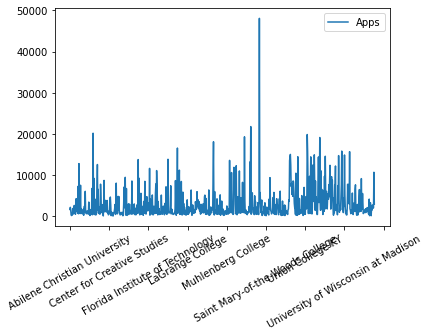

In [332]:
df.plot(y="Apps", rot=30)

In [326]:
train = df.sample(frac = 0.7)
test = df.loc[ df.index.difference(train.index) ]

In [327]:
train_X, train_y = train.drop(columns="Apps"), train.Apps
test_X, test_y = test.drop(columns="Apps"), test.Apps

In [328]:
model = LinearRegression().fit(train_X, train_y)

pred = model.predict(test_X)
mse = ( (pred - test_y)**2).mean()

In [329]:
mse

875743.0394700522

Usin a standard Linear regression, the test error is considerably high

In [350]:
alphas = np.e**np.linspace(0.5,15,5000)
model = RidgeCV(alphas=alphas).fit(train_X, train_y)

In [351]:
model.alpha_

27.562696781833512

In [353]:
pd.DataFrame(data=dict(zip(model.feature_names_in_, model.coef_)),
            index=[0])

Accept    Enroll  Top10perc  Top25perc  F.Undergrad  P.Undergrad  \
0  1.60956 -0.944887  56.507937 -15.449063     0.070308     0.063967   

   Outstate  Room.Board     Books  Personal       PhD  Terminal  S.F.Ratio  \
0 -0.097062     0.14616  0.040047  0.080727 -10.04671 -3.215082   18.10729   

   perc.alumni    Expend  Grad.Rate  Private_Yes  
0    -2.559266  0.084918  12.722404  -314.058816

In [354]:
pred = model.predict(test_X)
mse = ( (pred - test_y)**2).mean()
mse

874044.593891269

The test error obtained was a bit better than the LeastSquares Model, but it isn't a significant improval.

In [355]:
alphas = np.e**np.linspace(0.5,15,5000)
model = LassoCV(alphas=alphas).fit(train_X, train_y)

In [356]:
model.alpha_

15.430518504217835

In [357]:
pd.DataFrame(data=dict(zip(model.feature_names_in_, model.coef_)),
            index=[0])

Accept    Enroll  Top10perc  Top25perc  F.Undergrad  P.Undergrad  \
0  1.609522 -0.943555   56.02659 -15.090981     0.070101     0.063415   

   Outstate  Room.Board     Books  Personal       PhD  Terminal  S.F.Ratio  \
0 -0.097213     0.14635  0.040842  0.080252 -9.956112 -3.247616  16.400765   

   perc.alumni    Expend  Grad.Rate  Private_Yes  
0     -2.39296  0.084635  12.616867  -321.923477

In [358]:
pred = model.predict(test_X)
mse = ( (pred - test_y)**2).mean()
mse

872350.4519684406

Lasso model improved over the Ridge. But only a little improve as well

In [373]:
pcr = make_pipeline(StandardScaler(), PCA(n_components=2), LinearRegression())

In [374]:
pcr.fit(train_X, train_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('linearregression', LinearRegression())])

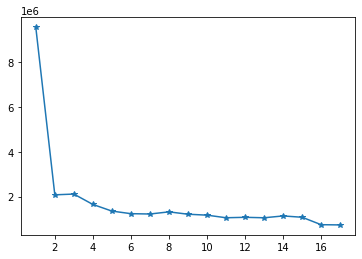

In [390]:
cv = KFold(n_splits=10, shuffle=True)

mse = []

for i in np.arange(1, len(train.columns)):
    pcr = make_pipeline(StandardScaler(), PCA(n_components=i), LinearRegression())
    pcr.fit(train_X, train_y)
    
    score = -cross_val_score(pcr, test_X, y=test_y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(range(1,len(train.columns)), mse, '-*')

In [392]:
model = make_pipeline(StandardScaler(), PCA(n_components=6), LinearRegression())
model.fit(train_X, train_y)
pred = model.predict(test_X)
print( ((pred-test_y)**2).mean() )

1894904.2922784896


In [394]:
model = make_pipeline(StandardScaler(), PCA(n_components=11), LinearRegression())
model.fit(train_X, train_y)
pred = model.predict(test_X)
print( ((pred-test_y)**2).mean() )

1706687.1594859178


In [396]:
model = make_pipeline(StandardScaler(), PCA(n_components=16), LinearRegression())
model.fit(train_X, train_y)
pred = model.predict(test_X)
print( ((pred-test_y)**2).mean() )

934769.2347880416


This method has obtained worse results than lasso or ridge

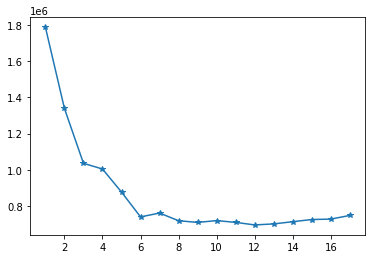

In [398]:
cv = KFold(n_splits=10, shuffle=True)

mse = []

for i in np.arange(1, len(train.columns)):
    pls = PLSRegression(n_components=i)
    pls.fit(train_X, train_y)
    
    score = -cross_val_score(pls, test_X, y=test_y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(range(1,len(train.columns)), mse, '-*')

In [401]:
model = PLSRegression(n_components=6)
model.fit(train_X, train_y)
pred = model.predict(test_X).flatten()
print( ((pred-test_y)**2).mean() )

895769.7758251514


In [402]:
model = PLSRegression(n_components=12)
model.fit(train_X, train_y)
pred = model.predict(test_X).flatten()
print( ((pred-test_y)**2).mean() )

882185.6167993444


In [407]:
model = PLSRegression(n_components=16)
model.fit(train_X, train_y)
pred = model.predict(test_X).flatten()
print( ((pred-test_y)**2).mean() )

875750.7902574347


The component selection has shown to be better in PLS than PCR, for this case, since that for the same number of components, the test error is considerably lower

In [410]:
800000/df.Apps.mean()**2

0.08879188079909565

Text(0, 0.5, 'RMSE')

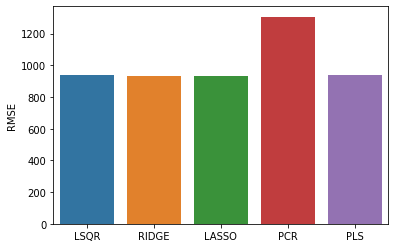

In [417]:
mse = [875743.0394700522, 874044.593891269, 872350.4519684406, 1706687.1594859178, 882185.6167993444]
mse = np.sqrt(mse)
labels = ["LSQR", "RIDGE", "LASSO", "PCR", "PLS"]
ax = sns.barplot(x = labels, y=mse)
ax.set_ylabel("RMSE")

The bar plot represents the RMSE for each model. We can see that all have aproximetly the same error, except for the PCR

In [418]:
np.random.seed(1)

In [439]:
p=20
n=1000
X = np.random.normal(size=(1000, p))
B = np.random.normal(size=p)

binary = np.round(np.random.random(p))
for i,j in enumerate(binary):
    B[int(i)]*=j

eps = np.random.normal(p)

In [460]:
Y = np.matrix(X) * np.matrix(B).T + eps

In [462]:
Y.shape

(1000, 1)

In [463]:
df = pd.DataFrame(X, columns=[f"X{i}" for i in range(1,21)])
df["Y"] = Y

In [465]:
train = df.sample(n=100)
test = df.loc[ df.index.difference(train.index) ]

X_train, y_train = train.drop(columns="Y"), train.Y
X_test, y_test = test.drop(columns="Y"), test.Y

In [538]:
models = bss(X_train, y_train)

1 --> 0.0699167251586914
2 --> 0.4909653663635254
3 --> 2.773272752761841
4 --> 11.835004091262817
5 --> 44.86670756340027
6 --> 108.79303336143494
7 --> 223.1052975654602
8 --> 337.6170268058777
9 --> 458.94032073020935
10 --> 477.2080841064453
11 --> 437.9693248271942
12 --> 369.75047397613525
13 --> 242.53003573417664
14 --> 128.31819868087769
15 --> 44.80227446556091
16 --> 14.027999639511108
17 --> 3.261258840560913
18 --> 0.5983569622039795
19 --> 0.06003379821777344
20 --> 0.005997180938720703


In [539]:
def calc_mse(model, X, y, add=False):
    if add:
        X = add_constant(X)
    pred = model.predict(X)
    mse = ((pred - y)**2).mean()
    return mse

In [469]:
os.makedirs("cap5/exercise9", exist_ok=True)

In [541]:
for i in models.index:
    #models.loc[i].model.save(f"cap5/exercise9/model_{i}")
    dump(models.loc[i].model, f"cap5/exercise9/model_{i}")

Text(0, 0.5, 'RMSE')

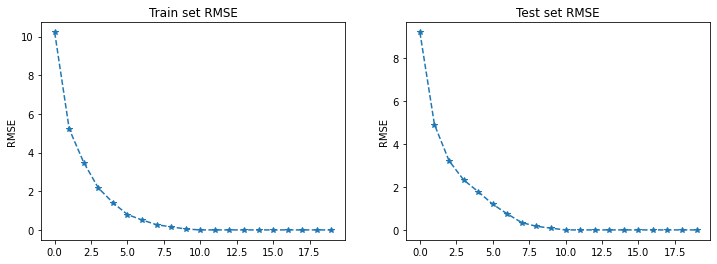

In [554]:
train_mse = []
test_mse = []
for index in models.index:
    model = models.loc[index, "model"]
    columns = models.loc[index, "columns"]
    
    pred = model.predict(X_train[ columns ])
    train_mse.append(((pred - y_train)**2).mean())
    
    pred = model.predict(X_test[ columns ])
    test_mse.append(((pred - y_test)**2).mean())

f, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(train_mse, "--*")
ax[0].set_title("Train set RMSE")
ax[0].set_ylabel("RMSE")

ax[1].plot(test_mse, "--*")
ax[1].set_title("Test set RMSE")
ax[1].set_ylabel("RMSE")

In [557]:
print( np.argmin(train_mse)+1,
      np.min(train_mse))
print( np.argmin(test_mse)+1,
       np.min(test_mse))

14 5.36425415550288e-30
14 8.155068735751437e-30


In both the test and train sets the 14 predictors model has the lowest RMSE

In [567]:
list(enumerate(B, start=1))

[(1, 0.6246756893378947),
 (2, 0.2857250261133114),
 (3, 1.0367709523421398),
 (4, 0.0),
 (5, -0.0),
 (6, -0.0),
 (7, 0.0),
 (8, -0.0),
 (9, 0.6815447488726489),
 (10, -0.8094085457706633),
 (11, -0.0),
 (12, 0.0),
 (13, -0.0),
 (14, 0.0),
 (15, 1.2161363407803223),
 (16, -0.25387089795880774),
 (17, 0.37544346347669916),
 (18, -0.5715073605640831),
 (19, 2.0234756369164195),
 (20, 2.064249305879501)]

In [566]:
models.loc[14].columns

array(['X1', 'X2', 'X3', 'X5', 'X7', 'X8', 'X9', 'X10', 'X15', 'X16',
       'X17', 'X18', 'X19', 'X20'], dtype=object)

A major part of the predictors that where nulled by B values were not selected in this scenario. 
Only included 3 of the 9 variables not considered in the calculus of Y.

In [570]:
m.coef_

array([ 6.24675689e-01,  2.85725026e-01,  1.03677095e+00, -4.99600361e-16,
       -1.38777878e-17,  3.88578059e-16,  6.81544749e-01, -8.09408546e-01,
        1.21613634e+00, -2.53870898e-01,  3.75443463e-01, -5.71507361e-01,
        2.02347564e+00,  2.06424931e+00])

In [571]:
m.feature_names_in_

array(['X1', 'X2', 'X3', 'X5', 'X7', 'X8', 'X9', 'X10', 'X15', 'X16',
       'X17', 'X18', 'X19', 'X20'], dtype=object)

In [575]:
cols = [f"X{i}" for i in range (1,p+1)]
d1 = pd.DataFrame(data = dict( zip(cols, B) ), index=[0] )

In [581]:
d1

X1        X2        X3   X4   X5   X6   X7   X8        X9       X10  \
0  0.624676  0.285725  1.036771  0.0 -0.0 -0.0  0.0 -0.0  0.681545 -0.809409   

   X11  X12  X13  X14       X15       X16       X17       X18       X19  \
0 -0.0  0.0 -0.0  0.0  1.216136 -0.253871  0.375443 -0.571507  2.023476   

        X20  
0  2.064249

In [582]:
d2

X1        X2        X3            X5            X7            X8  \
0  0.624676  0.285725  1.036771 -4.996004e-16 -1.387779e-17  3.885781e-16   

         X9       X10       X15       X16       X17       X18       X19  \
0  0.681545 -0.809409  1.216136 -0.253871  0.375443 -0.571507  2.023476   

        X20  X11  X12  X13  X14  X4  X6  
0  2.064249    0    0    0    0   0   0

In [615]:
cols = [f"X{i}" for i in range (1,p+1)]
d1 = pd.DataFrame(data = dict( zip(cols, B) ), index=[0] )

beta_error = []

for model in models.model:
    d2 = pd.DataFrame(data = dict(zip(model.feature_names_in_, model.coef_) ), index=[0] )
    for col in pd.Index(cols).difference(d2.columns):
        d2[col]=0
    diff = np.sqrt( np.sum( (d1-d2).to_numpy()**2 ) )
    beta_error.append(diff)

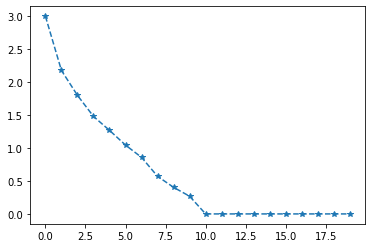

In [617]:
plt.plot(beta_error, "--*")

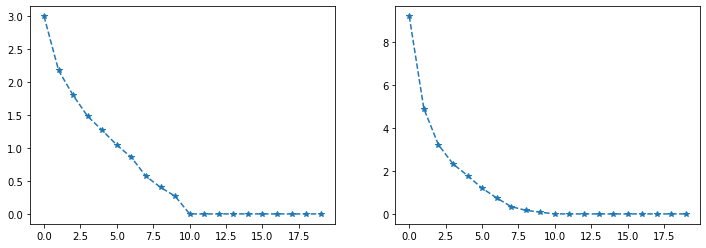

In [619]:
f, ax = plt.subplots(1,2, figsize = (12,4))

ax[0].plot(beta_error, "--*")

ax[1].plot(test_mse, "--*")

In [620]:
np.argmin(beta_error)

13

In [621]:
np.argmin(test_mse)

13

They both are minimized with the same number of predictors

In [625]:
df = get_rdataset("Boston", "MASS", cache=True).data

In [626]:
df.head()

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2

In [627]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [628]:
df.describe()

crim          zn       indus        chas         nox          rm  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              age         dis         rad         tax     ptratio       black  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     77.500000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            lstat        medv  
count  506.000000  506.000000  
mean    12.653063   22.532806  
std      7.141062    9.197104  
min      1.730000    5.000000  
25%      6.950000   17.025000  
50%     11.360000   21.200000  
75%     16.955000   25.000000  
max     37.970000   50.000000

<AxesSubplot:xlabel='medv'>

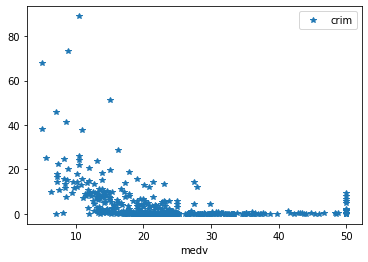

In [660]:
df.plot(x = "medv", y="crim", ls="", marker="*")

In [706]:
train = df.sample(frac = 0.5)
test = df.loc[df.index.difference(train.index)]

In [707]:
X_train, y_train = train.drop(columns="crim"), train.crim
X_test, y_test = test.drop(columns="crim"), test.crim

In [708]:
models = bss(X_train, y_train)

1 --> 0.03227972984313965
2 --> 0.18347430229187012
3 --> 0.7094748020172119
4 --> 1.7632148265838623
5 --> 3.222072124481201
6 --> 4.42987060546875
7 --> 4.444092750549316
8 --> 3.351966381072998
9 --> 1.908921241760254
10 --> 0.7662227153778076
11 --> 0.2161695957183838
12 --> 0.03126120567321777
13 --> 0.015613794326782227


<AxesSubplot:>

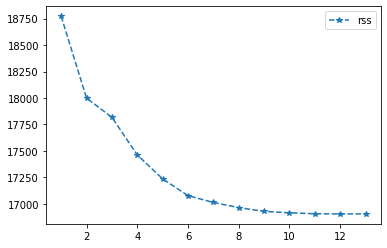

In [709]:
models.plot(y="rss", ls="--", marker="*")

In [710]:
models

model           rss  \
1   LinearRegression()  18772.805159   
2   LinearRegression()  17998.830277   
3   LinearRegression()  17817.778222   
4   LinearRegression()  17461.916778   
5   LinearRegression()  17235.439317   
6   LinearRegression()  17076.783692   
7   LinearRegression()  17012.291765   
8   LinearRegression()  16963.800188   
9   LinearRegression()  16927.870334   
10  LinearRegression()  16914.525042   
11  LinearRegression()  16905.608895   
12  LinearRegression()  16904.041126   
13  LinearRegression()  16904.033515   

                                              columns  
1                                               [rad]  
2                                         [rad, medv]  
3                                    [dis, rad, medv]  
4                                [zn, dis, rad, medv]  
5                           [zn, nox, dis, rad, medv]  
6                  [zn, nox, dis, rad, ptratio, medv]  
7              [zn, nox, rm, dis, rad, ptratio, medv]  
8       [zn, nox, rm, dis, rad, ptratio, lstat, medv]  
9   [zn, nox, rm, dis, rad, tax, ptratio, lstat, m...  
10  [zn, chas, nox, rm, dis, rad, tax, ptratio, ls...  
11  [zn, indus, chas, nox, rm, dis, rad, tax, ptra...  
12  [zn, indus, chas, nox, rm, age, dis, rad, tax,...  
13  [zn, indus, chas, nox, rm, age, dis, rad, tax,...

In [744]:
m = models.loc[11, "model"]
cols = models.loc[11, "columns"]

pred = m.predict(X_test[cols])
rmse = np.sqrt( ((y_test - pred)**2).mean() )
print(rmse)

4.009150305780375


Error very close to the mean of the variable we want to predict. Numerically it is lower then half the standard deviation, which a good indicator for the model, since it wont be too far from the true value.

In [713]:
alphas = np.logspace(1,15,4000)
m = RidgeCV(alphas=alphas).fit(X_train, y_train)

print(m.alpha_)
pred = m.predict(X_test)
rmse = np.sqrt( ((y_test - pred)**2).mean() )
print(rmse)

161.36225354206826
3.770923077438063


In [714]:
pd.DataFrame(data = dict(zip(m.feature_names_in_, m.coef_)), index=[0])

zn     indus      chas       nox        rm       age       dis  \
0  0.048706 -0.110659 -0.062396 -0.066631  0.291657  0.007278 -0.784108   

        rad       tax   ptratio     black     lstat      medv  
0  0.591838 -0.002953 -0.187491 -0.001667  0.087921 -0.221362

Test error as been improved by ridge regression

In [715]:
alphas = np.logspace(1,10,4000)
m = LassoCV(alphas=alphas).fit(X_train, y_train)

print(m.alpha_)
pred = m.predict(X_test)
rmse = np.sqrt( ((y_test - pred)**2).mean() )
print(rmse)

197.84454531291556
4.399452199594359


In [716]:
pd.DataFrame(data = dict(zip(m.feature_names_in_, m.coef_)), index=[0])

zn  indus  chas  nox   rm  age  dis  rad       tax  ptratio  black  lstat  \
0 -0.0    0.0  -0.0  0.0 -0.0  0.0 -0.0  0.0  0.026333      0.0   -0.0    0.0   

   medv  
0  -0.0

Lasso has had worse results than Ridge or OLS

In [717]:
mse = pd.Series(dtype=float)
cv = KFold(n_splits=10, shuffle=True)

for i in range(1, len(X_train.columns)):
    pcr = make_pipeline(StandardScaler(), PCA(n_components=i), LinearRegression())
    pcr.fit(X_train, y_train)
    
    mse.loc[i] = (-cross_val_score(pcr, X_test, y=y_test, cv=cv, scoring='neg_mean_squared_error').mean())

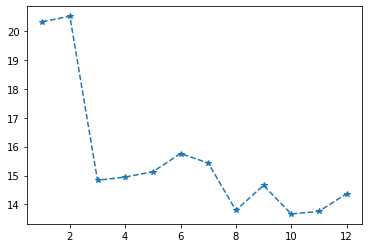

In [718]:
plt.plot(mse, "--*")

In [719]:
mse.argmin()

9

In [720]:
pcr = make_pipeline(StandardScaler(), PCA(n_components=10), LinearRegression())
pcr.fit(X_train, y_train)

pred = pcr.predict(X_test)
rmse = np.sqrt( ( (y_test - pred)**2 ).mean() )
print(rmse)

3.8400136133950595


In [724]:
pcr = make_pipeline(StandardScaler(), PCA(n_components=8), LinearRegression())
pcr.fit(X_train, y_train)

pred = pcr.predict(X_test)
rmse = np.sqrt( ( (y_test - pred)**2 ).mean() )
print(rmse)

3.894786322927489


8 or 10 predictors has close CV error on the test set.
The 10 variable model had better test error than the 8. 
Still, the difference is not much, and a simpler model should be the better option, thanks to explainability.

This model had better results than Lasso or OLS. Ridge is the best so far

In [735]:
mse = pd.Series(dtype=float)
cv = KFold(n_splits=10, shuffle=True)

for i in range(1, len(X_train.columns)):
    m = PLSRegression(n_components=i)
    m.fit(X_train, y_train)
    
    mse.loc[i] = (-cross_val_score(m, X_test, y=y_test, cv=cv, scoring='neg_mean_squared_error').mean())

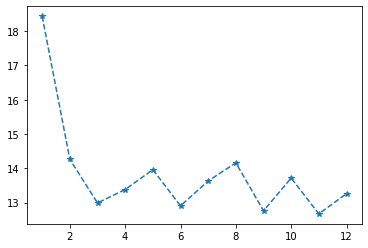

In [736]:
plt.plot(mse, "--*")

In [727]:
mse.argmin()

9

In [737]:
m = PLSRegression(n_components=11)
m.fit(X_train, y_train)

pred = m.predict(X_test).flatten()
rmse = np.sqrt( ( (y_test - pred)**2 ).mean() )
print(rmse)

4.00897872282081


In [738]:
m = PLSRegression(n_components=9)
m.fit(X_train, y_train)

pred = m.predict(X_test).flatten()
rmse = np.sqrt( ( (y_test - pred)**2 ).mean() )
print(rmse)

4.008837664551399


In [739]:
m = PLSRegression(n_components=6)
m.fit(X_train, y_train)

pred = m.predict(X_test).flatten()
rmse = np.sqrt( ( (y_test - pred)**2 ).mean() )
print(rmse)

4.009202669099362


In [740]:
m = PLSRegression(n_components=3)
m.fit(X_train, y_train)

pred = m.predict(X_test).flatten()
rmse = np.sqrt( ( (y_test - pred)**2 ).mean() )
print(rmse)

3.9810680013824626


In [732]:
m = PLSRegression(n_components=3)
m.fit(X_train, y_train)

pred = m.predict(X_test).flatten()
rmse = np.sqrt( ( (y_test - pred)**2 ).mean() )
print(rmse)

3.9810680013824626


The CV shows very close results for a large set of models. In the test set, the better model is the one with 3 predictors only.

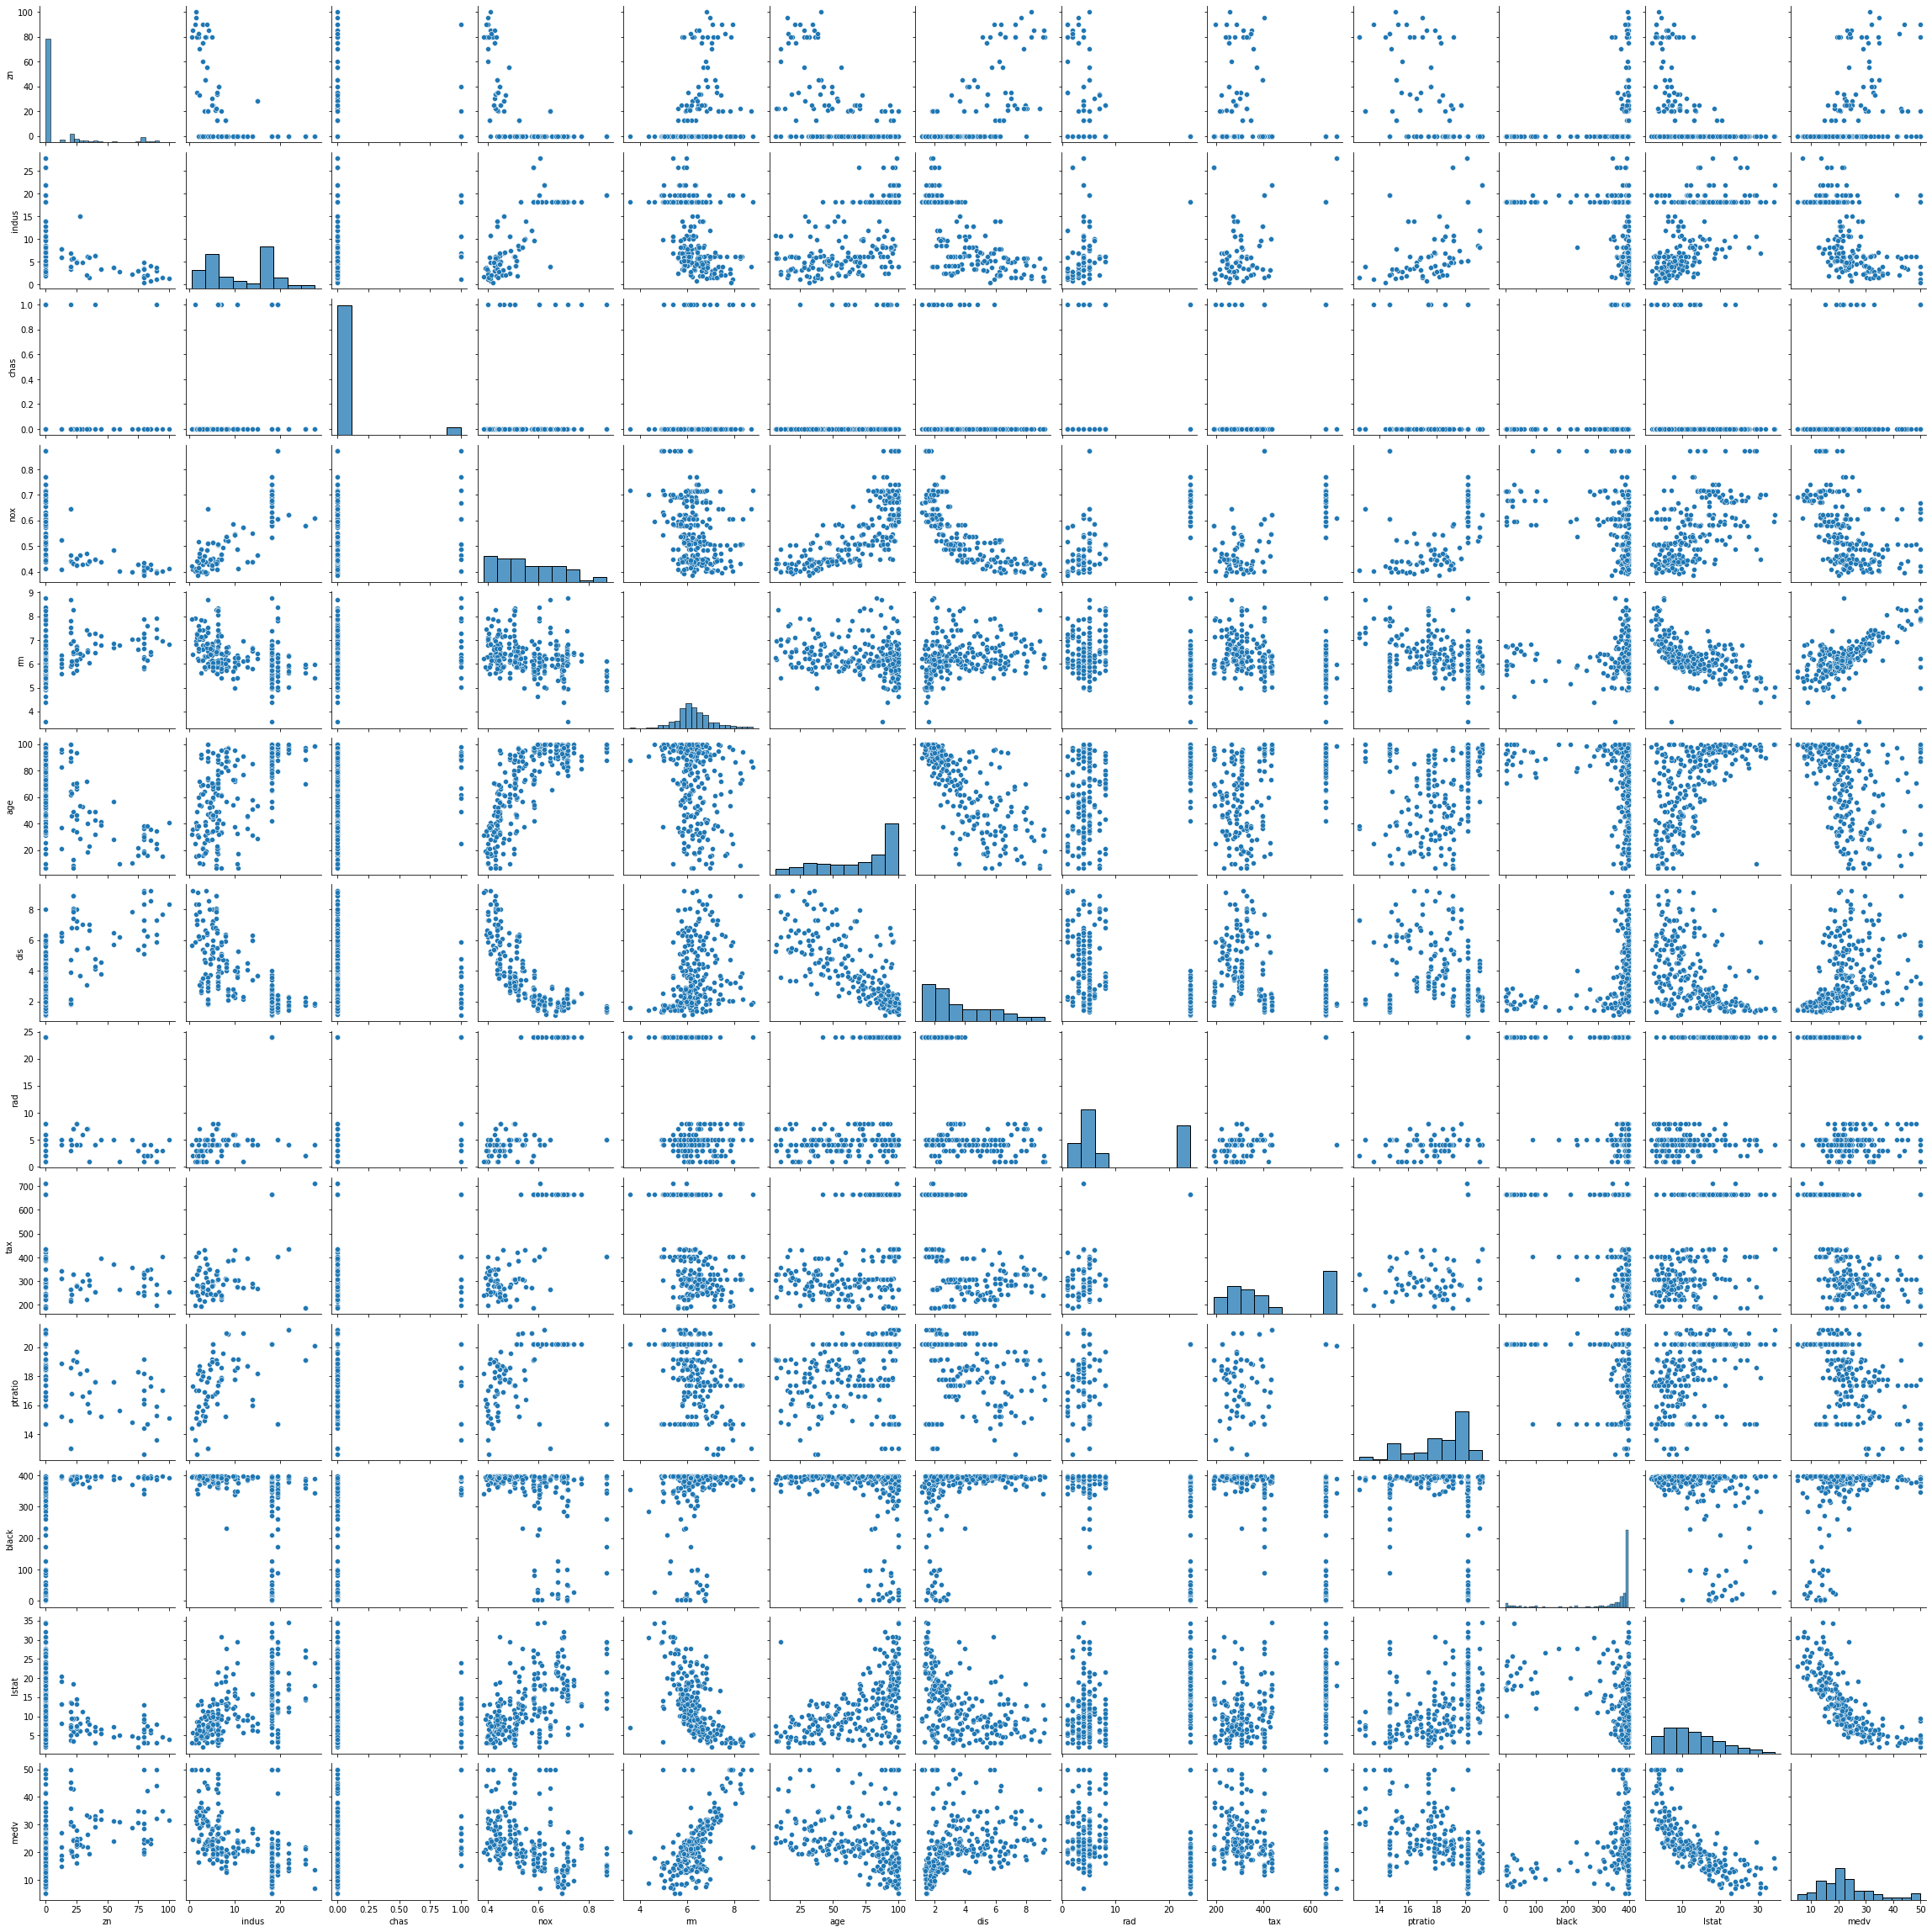

In [742]:
sns.pairplot(X_train)